<a href="https://colab.research.google.com/github/imauriciolopez/gradcam_desde_cero/blob/main/gcdc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title iniciar las librerías

import numpy as np
from skimage.transform import resize
from PIL import Image, ImageOps
import cv2

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.applications import VGG19

from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import matplotlib.colors
import random
from IPython.display import clear_output
import time
from matplotlib import ticker

In [ ]:
#@title hello world

model = VGG19(input_shape = (224,224,3), include_top = True, weights='imagenet')

img_size  = model.input.shape[1:3]

last_conv_layer_name   = 'block5_conv4' #aquí va la capa en la que quieres probar el algoritmo
brillo = 0.2
img_path = '/content/gb14.jpeg' #aquí va la imágen que quieres probar

indexx = -1
gc = gcdc()
gc.predicciones(model, img_path, verbose=True)
kk = gc.heatmap_con_imagen(model, img_path, last_conv_layer_name,
                      index = indexx, verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_VIRIDIS, brillo_imagen=brillo,
                      normalizacion = True, show_image=True)
gc.heatmap_solo(model, img_path, last_conv_layer_name,
                      index = indexx, verbose = True, relu_gradients = True, colormap=cv2.COLORMAP_JET, brillo_heatmap=0.9,
                      normalizacion = True, show_image=True)
kk.save("gb14especial.png")#aquí va el nombre que le quieres dar a la foto con gradcam
print(gc.predicciones(model = model, img_path=img_path))


574710816/574710816 [==============================] - 17s 0us/step


NameError: name 'gcdc' is not defined

In [ ]:
#@title montar el drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Clase original
class gcdc:
  #para un método que es estático no tienes que crear una instancia de la clase, para un método no estático si tienes que
  @staticmethod
  def get_img_array(img_path, model):
      img_size=model.input.shape[1:3]
      img = Image.open(img_path)
      img = img.resize(size=img_size)
      #print(f'format: {img.format}, shape: {img.size}, mode: {img.mode}')
      img_array = np.array(img)
      if len(img_array.shape) == 3:
        img_array = img_array[:, :, :3]
      elif len(img_array.shape) == 2:
        img_array = resize(img_array, (224, 224, 3))
      img_array =  img_array.astype('float32')
      img_array = np.expand_dims(img_array, axis=0)
      return img, img_array

  @staticmethod
  def get_img_array_natural(img_path):
      img = Image.open(img_path)
      return img

  def mostrar_imagen(self, img_path, model):
      img_size=model.input.shape[1:3]
      img, _ = self.get_img_array(img_path, img_size)
      imash = Image.fromarray(img, 'RGB')
      display(imash)
      return None

  def mostrar_imagen_natural(self, img_path):
      img = self.get_img_array_natural(img_path)
      imash = Image.fromarray(img, 'RGB')
      display(imash)
      return None

  def predicciones(self, model, img_path, verbose=False):
    _, img_array = self.get_img_array(img_path, model)
    preds = model.predict(img_array)
    decode_predictions = keras.applications.vgg19.decode_predictions
    decoded_predictions=decode_predictions(preds, top=10)[0]
    if verbose:
      print("{:10} {:20} {:10}".format('Id. clase', 'Nombre', 'Probabilidad'))
      print(22*' -')
      for decoded in decoded_predictions:
          print("{:10s} {:25s} {:0.5}".format(decoded[0], decoded[1], decoded[2]))
    print("\n.\n.\n.")
    return tf.argmax(preds[0])

  def make_gradcam_heatmap(self, img_path, model, last_conv_layer_name, index = -1, verbose = False, relu_gradients = True):
      _, img_array = self.get_img_array(img_path, model)
      # grad_model tiene 2 salidas, la salida de la ultima capa convolucional y la salida normal del modelo
      last_conv_layer  = model.get_layer(last_conv_layer_name)
      grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
      if index == -1:#explicado en tesis
        with tf.GradientTape() as tape:
            inputs = tf.cast(img_array, tf.float32)
            tape.watch(inputs)
            #definiendo la variable de gradiente
            conv_outputs, predictions = grad_model(inputs)
            top_pred_index = tf.argmax(predictions[0])
            if verbose:
              print('index = ',top_pred_index)
            top_class_channel = predictions[:, top_pred_index]
            print(top_class_channel)
      else:
        with tf.GradientTape() as tape:
            inputs = tf.cast(img_array, tf.float32)
            tape.watch(inputs)
            #definiendo la variable de gradiente
            conv_outputs, predictions = grad_model(inputs)
            top_class_channel = predictions[:, index]
      # Gradientes via backprop de la clase predicha (yc) con respecto del feature map, o sea el conv_output (ak)
      # es decir dyc/dak
      grads = tape.gradient(top_class_channel, conv_outputs)#explicado en tesis
      #gradientes con ReLU
      if relu_gradients:
        grads = (tf.cast(conv_outputs > 0, "float32")* tf.cast(grads > 0, "float32")* grads)#ver si es haddamard o canónica
      # global average pooling de los gradientes
      pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
      # salida de la última capa convolucional
      conv_outputs = conv_outputs.numpy()[0]
      pooled_grads = pooled_grads.numpy()
      for i in range(pooled_grads.shape[-1]):
          #combinación lineal de la salida de la ultima capa convolucional y el los gradientes pool
          conv_outputs[:, :, i] *= pooled_grads[i]
      grad_cam = np.mean(conv_outputs, axis=-1)
      #ReLU a la combinación lineal
      grad_cam = np.maximum(grad_cam, 0)
      return grad_cam

  def heatmap_con_imagen(self, model, img_path, last_conv_layer_name,
                      index = -1, verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_JET, brillo_imagen=0.1,
                      normalizacion = True, show_image=False):
      heatmap = self.make_gradcam_heatmap(img_path, model, last_conv_layer_name, index, verbose, relu_gradients)
      img = cv2.imread(img_path)
      img = cv2.resize(img, (255, 255))
      heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
      if normalizacion:
        if (heatmap.max() - heatmap.min()) != 0:
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
      heatmap = cv2.applyColorMap(cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), colormap)
      output = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR),brillo_imagen,heatmap, 1 - brillo_imagen,0,)
      imagen = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
      imash = Image.fromarray(imagen, 'RGB')
      if verbose:
        self.predicciones(model, img_path)
      if show_image:
        display(imash)
      return imash

  def heatmap_solo(self, model, img_path, last_conv_layer_name,
                      index = -1, verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_JET, brillo_heatmap=0.1,
                      normalizacion = True, show_image=False):
      heatmap = self.make_gradcam_heatmap(img_path, model, last_conv_layer_name, index, verbose, relu_gradients)
      img = np.zeros([255,255,3],dtype=np.uint8)
      img.fill(255)
      heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
      if normalizacion:
        if (heatmap.max() - heatmap.min()) != 0:
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
      heatmap = cv2.applyColorMap(cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), colormap)
      output = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR),brillo_heatmap,heatmap, 1 - brillo_heatmap,0,)
      imagen = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
      imash = Image.fromarray(imagen, 'RGB')
      if verbose:
        self.predicciones(model, img_path)
      if show_image:
        display(imash)
      return imash


In [ ]:
# @title resumen de red
from keras.applications import VGG19

def resumen(model=None):
    '''
    '''
    header = '{:4} {:16} {:24} {:24} {:10}'.format('#', 'Layer Name','Layer Input Shape','Layer Output Shape','Parameters'
    )
    print('='*(len(header)))
    print(header)
    print('='*(len(header)))
    count=0
    count_trainable=0
    for i, layer in enumerate(model.layers):
        count_trainable += layer.count_params() if layer.trainable else 0
        input_shape = '{}'.format(layer.input_shape)
        output_shape = '{}'.format(layer.output_shape)
        str = '{:<4d} {:16} {:24} {:24} {:10}'.format(i,layer.name, input_shape, output_shape, layer.count_params())
        print(str)
        count += layer.count_params()
    print('_'*(len(header)))
    print('Total Parameters : ', count)
    print('Total Trainable Parameters : ', count_trainable)
    print('Total No-Trainable Parameters : ', count-count_trainable)

vgg16 = VGG19(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))

resumen(vgg16)


In [ ]:
# @title experimentos

#declaración funciones
def grrdkm_htmpimg (abreviacion,apellido,numero, img_path, model, last_conv_layer_name,index = 404,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_JET,
            brillo_imagen=0.2,normalizacion = True, show_image=True):
    directorioentrada,abreviacion,apellido,layer,weight,index,numero = str(img_path),str(abreviacion),str(apellido),str(last_conv_layer_name),float(brillo_imagen),int(index),str(int(numero))
    nombre =  abreviacion  + numero + str('_gc_') + apellido + str('.png')
    directorio = str('/content/drive/MyDrive/gradcam2experimentos/gradcam6/con_heatmap/') + abreviacion+ str('/') + nombre
    gc = gcdc()
    grid = gc.heatmap_con_imagen(model, directorioentrada, layer,
                      index = index, verbose = verbose, relu_gradients = relu_gradients, colormap=colormap, brillo_imagen=weight,
                      normalizacion = normalizacion, show_image=show_image)
    grid.save(directorio)
    return 0

def grrdkm (abreviacion,apellido,numero, img_path, model, last_conv_layer_name,index = 404,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_JET,
            brillo_imagen=0,normalizacion = True, show_image=True):
    directorioentrada,abreviacion,apellido,layer,weight,index,numero = str(img_path),str(abreviacion),str(apellido),str(last_conv_layer_name),float(brillo_imagen),int(index),str(int(numero))
    nombre =  abreviacion  + numero + str('_gc_') + apellido + str('.png')
    directorio = str('/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/') + abreviacion+ str('/') + nombre
    gc = gcdc()
    grid = gc.heatmap_solo(model, directorioentrada, layer,
                      index = index, verbose = verbose, relu_gradients = relu_gradients, colormap=colormap, brillo_heatmap=weight,
                      normalizacion = normalizacion, show_image=show_image)
    grid.save(directorio)
    return 0

def indexpredicho (model, img_path): #dice el index que predice la red
    gc = gcdc()
    return gc.predicciones(model = model, img_path=img_path)

def mockgrrdkm (abreviacion,apellido,numero, img_path, model, last_conv_layer_name,
                index = 404, verbose = False, relu_gradients = True,
                colormap=cv2.COLORMAP_JET, brillo_imagen=brillo,normalizacion = True,
                show_image=True):
    directorioentrada,abreviacion,apellido,layer,weight,index,numero = str(img_path),str(abreviacion),str(apellido),str(last_conv_layer_name),float(brillo_imagen),int(index),str(int(numero))
    nombre =  abreviacion  + numero + str('_gc_') + apellido + str('.png')
    directorio = str('/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/') + abreviacion+ str('/') + nombre
    print(directorioentrada,directorio,abreviacion,numero,apellido,layer,index,colormap,normalizacion)
    return 0 #solo imprime los datos que se le dan a la función gradcam para comprobar que son los correctos y dar fe de en qué paso va

#declaración de variables
dictobjetos = {'hc':'599','mi':'657','ob':'682','na':'677','pb':'719','sb':'779','sv':'792','sw':'809','se':'815','wp':'895','ic':'928','vc':'980','cr':'987','lb':'625','ip':'605','gb':'574','eg':'546','cw':'479','bt':'435','ai':'404'}
inicio = str('/content/drive/MyDrive/gradcam2experimentos/originales/')
layers = ['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool','block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1','block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2','block5_conv3', 'block5_conv4', 'block5_pool']
directoriosoriginales = ['a','a','a','a','a','a','a','a','a','a','a','a','a','a','a','a','a','a','a','a']
brillo=0.0
brillo_imagen = 0.4

cuentas = {}

indexes = {}
objeto={}

estring = []
eestring = []
prrera = []


countsi = 0
countno = 0
countsiloc = 0
countnoloc = 0

for xd in range(20):
  #declaración nombres
  xdd=xd+0
  objetos = str(list(dictobjetos.items())[xdd][0])
  index = int(list(dictobjetos.items())[xdd][1])
  for i in range(20):
    directoriosoriginales[i] = inicio+objetos+str('/')+objetos+str(i+1)+str('.jpeg')
  #declaración variables
  indexran = 0
  f = np.random.randint(1,high=1000)
  if f!=index:
    indexran = f
  else:
    indexran = f+1
  print('\nVARIACION DE LayerName\n')
  #VARIACION DE LAYERNAME

  for i in range(20):
    for layer in layers:

      grrdkm(objetos,layer,i+1, directoriosoriginales[i], model, layer,index = index,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)
      grrdkm_htmpimg(objetos,layer,i+1, directoriosoriginales[i], model, layer,index = index,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_JET,
            brillo_imagen=brillo_imagen,normalizacion = True, show_image=False)
      mockgrrdkm(objetos,layer,i+1, directoriosoriginales[i], model, last_conv_layer_name,index = index,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)


  #VARIACION DE GUIDED GRADS CON INDEX
  print('\nVARIACION DE GRADS INDEX\n')
  for i in range(20):
    indexpredicho = gcdc().predicciones(model = model, img_path=directoriosoriginales[i])
    if indexpredicho == index:
        apellidomaterno = str('eq')
        countsi += 1
        countsiloc +=1
    else:
        apellidomaterno = str('neq')
        countno += 1
        countnoloc += 1

    prrera.append(int(indexpredicho))
    prrera.append(index)
    prrera.append(indexran)
    objeto[i] = prrera
    estring.append(objeto)
    prrera = []
    objeto = {}


    apellidopredichotrue = str('predicho_true_') + apellidomaterno
    grrdkm(objetos,apellidopredichotrue,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = -1,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)
    grrdkm_htmpimg(objetos,apellidopredichotrue,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = -1,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_JET,
            brillo_imagen=brillo_imagen,normalizacion = True, show_image=False)
    mockgrrdkm(objetos,apellidopredichotrue,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = -1,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)


    apellidorealtrue = str('real_true_') + apellidomaterno
    grrdkm(objetos,apellidorealtrue,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = index,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)
    grrdkm_htmpimg(objetos,apellidorealtrue,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = index,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_JET,
            brillo_imagen=brillo_imagen,normalizacion = True, show_image=False)
    mockgrrdkm(objetos,apellidorealtrue,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = index,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)


    apellidorandomtrue = str('random_true_') + apellidomaterno +str(indexran)
    grrdkm(objetos,apellidorandomtrue,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = indexran,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)
    grrdkm_htmpimg(objetos,apellidorandomtrue,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = indexran,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_JET,
            brillo_imagen=brillo_imagen,normalizacion = True, show_image=False)
    mockgrrdkm(objetos,apellidorandomtrue,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = indexran,
            verbose = False, relu_gradients = True, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)




    apellidopredichofalse = str('predicho_false_') + apellidomaterno
    grrdkm(objetos,apellidopredichofalse,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = -1,
            verbose = False, relu_gradients = False, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)
    grrdkm_htmpimg(objetos,apellidopredichofalse,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = -1,
            verbose = False, relu_gradients = False, colormap=cv2.COLORMAP_JET,
            brillo_imagen=brillo_imagen,normalizacion = True, show_image=False)
    mockgrrdkm(objetos,apellidopredichofalse,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = -1,
            verbose = False, relu_gradients = False, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)


    apellidorealfalse = str('real_false_') + apellidomaterno
    grrdkm(objetos,apellidorealfalse,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = index,
            verbose = False, relu_gradients = False, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)
    grrdkm_htmpimg(objetos,apellidorealfalse,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = index,
            verbose = False, relu_gradients = False, colormap=cv2.COLORMAP_JET,
            brillo_imagen=brillo_imagen,normalizacion = True, show_image=False)
    mockgrrdkm(objetos,apellidorealfalse,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = index,
            verbose = False, relu_gradients = False, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)


    apellidorandomfalse = str('random_false_') + apellidomaterno + str(indexran)
    grrdkm(objetos,apellidorandomfalse,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = indexran,
            verbose = False, relu_gradients = False, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)
    grrdkm_htmpimg(objetos,apellidorandomfalse,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = indexran,
            verbose = False, relu_gradients = False, colormap=cv2.COLORMAP_JET,
            brillo_imagen=brillo_imagen,normalizacion = True, show_image=False)
    mockgrrdkm(objetos,apellidorandomfalse,i+1, directoriosoriginales[i], model, 'block5_conv4' ,index = indexran,
            verbose = False, relu_gradients = False, colormap=cv2.COLORMAP_VIRIDIS,
            brillo_imagen=brillo,normalizacion = True, show_image=False)

  indexes[objetos] = estring
  estring = []
  eestring.append(countsiloc)
  eestring.append(countnoloc)
  countsiloc = 0
  countnoloc = 0
  cuentas[objetos] = eestring

print(countsi,countno)
print(cuentas)
print(indexes)


Se han truncado las últimas 5000 líneas del flujo de salida.
/content/drive/MyDrive/gradcam2experimentos/originales/cr/cr9.jpeg /content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/cr/cr9_gc_block1_conv1.png cr 9 block1_conv1 block5_conv4 987 16 True
/content/drive/MyDrive/gradcam2experimentos/originales/cr/cr9.jpeg /content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/cr/cr9_gc_block1_conv2.png cr 9 block1_conv2 block5_conv4 987 16 True
/content/drive/MyDrive/gradcam2experimentos/originales/cr/cr9.jpeg /content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/cr/cr9_gc_block1_pool.png cr 9 block1_pool block5_conv4 987 16 True
/content/drive/MyDrive/gradcam2experimentos/originales/cr/cr9.jpeg /content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/cr/cr9_gc_block2_conv1.png cr 9 block2_conv1 block5_conv4 987 16 True
/content/drive/MyDrive/gradcam2experimentos/originales/cr/cr9.jpeg /content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/c

In [ ]:
# @title concats
def get_concat_varios_h(im1,im2,im3,im4,im5):
    conc1=get_concat_h(im1,im2)
    conc2=get_concat_h(im3,im4)
    conc3=get_concat_h(conc2,im5)
    concfin=get_concat_h(conc1,conc3)
    return concfin

def get_concat_varios_v(im1,im2,im3,im4):
    conc1=get_concat_v(im1,im2)
    conc2=get_concat_v(im3,im4)
    concfin=get_concat_v(conc1,conc2)
    return concfin

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

imagenes=[]
for i in range(20):
  f=i+1
  folder = str("/content/drive/MyDrive/gradcam2experimentos/imagenes_para_concat/gb")
  #num = str("gc")+str(f)+str(".jpeg")
  num =str(f)+str("_gc_block5_pool.png")
  totstr=folder+num
  imagenes.append(totstr)

im1 = Image.open(imagenes[0])
im1 = im1.resize((224, 224))
im2 = Image.open(imagenes[1])
im2 = im2.resize((224, 224))
im3 = Image.open(imagenes[2])
im3 = im3.resize((224, 224))
im4 = Image.open(imagenes[3])
im4 = im4.resize((224, 224))
im5 = Image.open(imagenes[4])
im5 = im5.resize((224, 224))
im6 = Image.open(imagenes[5])
im6 = im6.resize((224, 224))
im7 = Image.open(imagenes[6])
im7 = im7.resize((224, 224))
im8 = Image.open(imagenes[7])
im8 = im8.resize((224, 224))
im9 = Image.open(imagenes[8])
im9 = im9.resize((224, 224))
im10 = Image.open(imagenes[9])
im10 = im10.resize((224, 224))
im11 = Image.open(imagenes[10])
im11 = im11.resize((224, 224))
im12 = Image.open(imagenes[11])
im12 = im12.resize((224, 224))
im13 = Image.open(imagenes[12])
im13 = im13.resize((224, 224))
im14 = Image.open(imagenes[13])
im14 = im14.resize((224, 224))
im15 = Image.open(imagenes[14])
im15 = im15.resize((224, 224))
im16 = Image.open(imagenes[15])
im16 = im16.resize((224, 224))
im17 = Image.open(imagenes[16])
im17 = im17.resize((224, 224))
im18 = Image.open(imagenes[17])
im18 = im18.resize((224, 224))
im19 = Image.open(imagenes[18])
im19 = im19.resize((224, 224))
im20 = Image.open(imagenes[19])
im20 = im20.resize((224, 224))

conc1=get_concat_varios_h(im1, im2, im3, im4, im5)
conc2=get_concat_varios_h(im6, im7, im8, im9, im10)
conc3=get_concat_varios_h(im11, im12, im13, im14, im15)
conc4=get_concat_varios_h(im16, im17, im18, im19, im20)

get_concat_varios_v(conc1,conc2,conc3,conc4).save("/content/drive/MyDrive/gradcam2experimentos/concats/gb_gc_block5_pool.png")



NameError: name 'Image' is not defined

<ipython-input-4-82158ef3a36b>:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(layers_diminutivos, rotation=90, size = 7)


"\nfor k in range(cuantas_imagenes):\n  fig_dists, axs_dists = plt.subplots(cuantos_graficos_por_imagen_altura, cuantos_graficos_por_imagen_anchura)\n  for i in range(cuantos_graficos_por_imagen_altura):\n    for g in range(cuantos_graficos_por_imagen_anchura):\n      objeto = list(dictobjetos.items())[contador][0]\n      lista = list(dict_dists.items())[contador][1]\n      colors = str(colores[ran_color[contador]])\n      axs_dists[i, g].plot(layers_diminutivos,lista, color = colors)\n      axis = objeto\n      axs_dists[i, g].set_title(axis,fontdict={'fontsize': 13,'verticalalignment': 'baseline'})\n      contador += 1\n  for ax in axs_dists.flat:\n      ax.set(xlabel='Capas', ylabel='Blobs dists.')\n      ax.set_xticklabels(layers_diminutivos, rotation=90, size = 7)\n      ylabel = np.linspace(2*min(list(dict_dists.items())[kontador][1])-max(list(dict_dists.items())[kontador][1]),max(list(dict_dists.items())[kontador][1]),num=10)\n      kontador += 1\n  fig_dists.tight_layout()\n  n

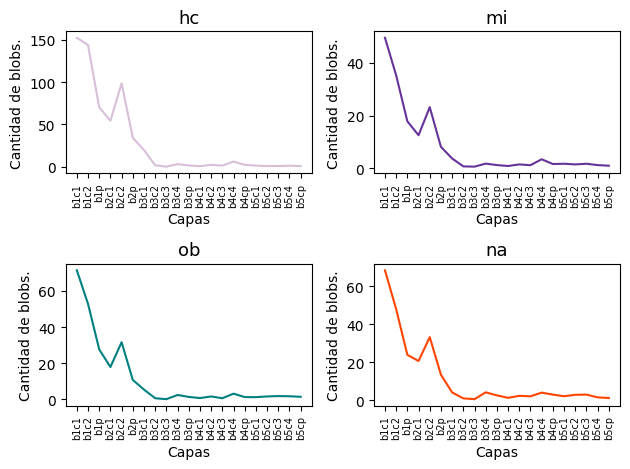

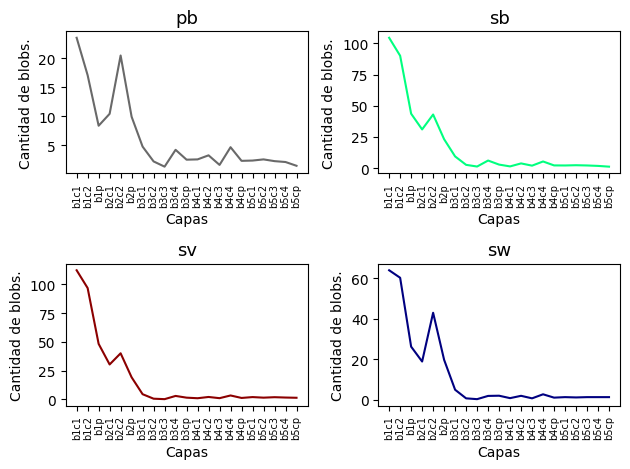

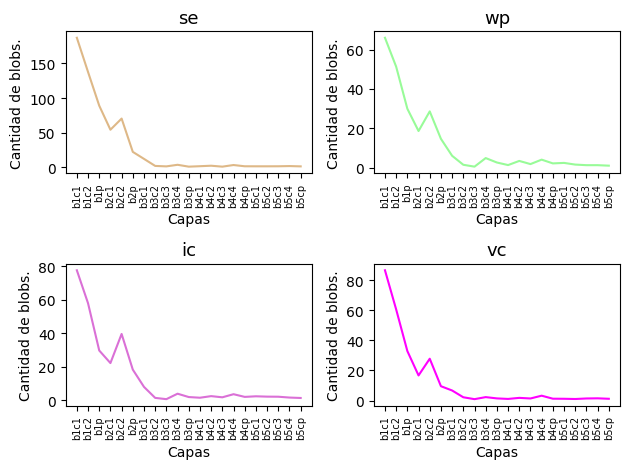

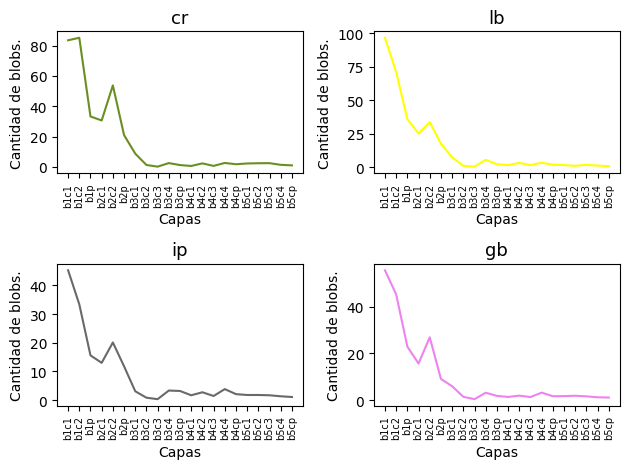

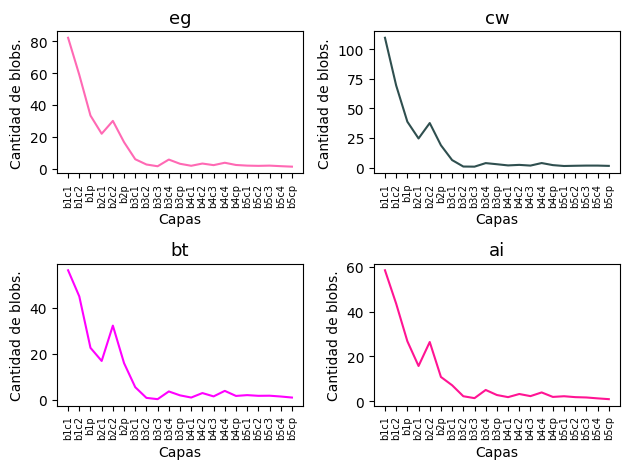

In [ ]:
# @title detección y tracking de blobs

start_time = time.time()
'''
def detect_blobs (direccion,threshold,area):
  im2 = cv2.imread(direccion, cv2.IMREAD_GRAYSCALE)
  im2 = 255 - im2
  cv2.imwrite("/content/reescribe.jpeg",im2)
  params = cv2.SimpleBlobDetector_Params()
  params.minThreshold = 1
  params.maxThreshold = threshold
  params.filterByArea = True
  params.minArea = area
  params.filterByCircularity = False
  params.filterByConvexity = False
  params.filterByInertia = False
  detector = cv2.SimpleBlobDetector_create(params)
  keypointsz = detector.detect(im2)
  return keypointsz,len(keypointsz)

def distanciattl (keypoints):
  distancia = 0
  ptos = np.array([keypoints.pt for keypoints in keypoints]).reshape(-1, 1, 2)
  for i in range(len(ptos)):
    for g in range(len(ptos)-i):
      h = i+g
      if i != h:
        distancia_x = tuple(ptos[i])[0][0]-tuple(ptos[h])[0][0]
        distancia_y = tuple(ptos[i])[0][1]-tuple(ptos[h])[0][1]
        distanciacuadrada = (distancia_x**2+distancia_y**2)
        distancia = distancia + np.sqrt(distanciacuadrada)
  return distancia
'''
colores = ['black', 'dimgray', 'dimgrey', 'gray', 'grey', 'darkgray', 'rosybrown', 'lightcoral', 'indianred', 'brown', 'firebrick','maroon', 'darkred', 'red', 'salmon', 'tomato', 'darksalmon', 'coral', 'orangered','lightsalmon', 'sienna', 'chocolate', 'saddlebrown', 'sandybrown', 'peachpuff', 'peru','bisque', 'darkorange', 'burlywood','tan', 'orange','darkgoldenrod', 'goldenrod','gold', 'khaki', 'palegoldenrod', 'darkkhaki', 'olive', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'greenyellow','chartreuse', 'lawngreen', 'darkseagreen', 'palegreen', 'lightgreen', 'forestgreen', 'limegreen','darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'springgreen','mediumspringgreen','mediumaquamarine', 'aquamarine', 'turquoise', 'lightseagreen', 'mediumturquoise','darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'aqua', 'cyan', 'darkturquoise','cadetblue', 'powderblue', 'lightblue', 'deepskyblue', 'skyblue', 'lightskyblue', 'steelblue','dodgerblue', 'lightslategray', 'lightslategrey', 'slategray', 'slategrey', 'lightsteelblue', 'cornflowerblue','royalblue', 'midnightblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue','darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid','darkviolet', 'mediumorchid', 'thistle', 'plum', 'violet', 'purple', 'darkmagenta', 'fuchsia', 'magenta','orchid', 'mediumvioletred', 'deeppink', 'hotpink','palevioletred', 'crimson', 'pink','lightpink']
dictobjetos = {'hc':'599','mi':'657','ob':'682','na':'677','pb':'719','sb':'779','sv':'792','sw':'809','se':'815','wp':'895','ic':'928','vc':'980','cr':'987','lb':'625','ip':'605','gb':'574','eg':'546','cw':'479','bt':'435','ai':'404'}
layers = ['block1_conv1', 'block1_conv2', 'block1_pool','block2_conv1', 'block2_conv2', 'block2_pool','block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1','block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2','block5_conv3', 'block5_conv4', 'block5_pool']
layers_diminutivos = ['b1c1','b1c2','b1p','b2c1','b2c2','b2p','b3c1','b3c2','b3c3','b3c4','b3cp','b4c1','b4c2','b4c3','b4c4','b4cp','b5c1','b5c2','b5c3','b5c4','b5cp']
'''
inicio = str('/content/drive/MyDrive/gradcam2experimentos/gradcam/')
jpeg = str('.jpeg')
barra = str('/')
threshold = int(input('Threshold = '))
area = int(input('Area = '))
'''
cuantos_graficos_por_imagen_altura = 2
cuantos_graficos_por_imagen_anchura = 2
cuantas_imagenes = 5
numero = cuantos_graficos_por_imagen_altura*cuantos_graficos_por_imagen_anchura
ran_color = random.sample(range(1, len(colores)), numero*cuantas_imagenes)

kounter_strike = 0
'''
distancias_list = []
blobs_list = []
for clase in dictobjetos.keys():
  objeto = str(clase)
  for layer in layers:
    leyer = str(layer)
    for i in range(20):
      num = str(i)
      kounter_strike += 1
      carga = (kounter_strike/8400)*100
      taim = time.time()
      proyeccion = (((taim-start_time)/60)-(((100*(taim-start_time))/carga)/60))
      print('cargando -> ',carga,'%\n')
      print('proyección en minutos restantes -> ',proyeccion,' minutos')
      direccion = inicio + objeto + barra + objeto + num + str('_gc_') + leyer + jpeg
      keypoints, blobs = detect_blobs(direccion,threshold,area)
      distancia += distanciattl(keypoints)
      blob += blobs
      clear_output()
    distancias_list.append(distancia)
    distancia = 0
    blobs_list.append(blob)
    blob = 0
  dict_dists[objeto] = list(distancias_list)
  distancias_list = []
  dict_blobs[objeto] = list(blobs_list)
  blobs_list = []
'''

dict_blobs = {'hc': [2207, 2006, 1634, 2001, 2361, 1815, 1796, 1594, 1378, 1383, 1289, 1282, 1327, 1280, 1412, 1258, 1208, 1150, 1129, 1133, 1177], 'mi': [669, 647, 579, 583, 695, 529, 489, 392, 330, 383, 345, 337, 348, 340, 407, 282, 295, 310, 292, 276, 272], 'ob': [955, 987, 843, 767, 916, 672, 558, 511, 459, 514, 449, 456, 472, 446, 519, 414, 437, 414, 430, 433, 426], 'na': [952, 853, 810, 759, 862, 732, 619, 591, 568, 597, 561, 564, 558, 571, 583, 530, 469, 496, 485, 473, 490], 'pb': [421, 402, 357, 420, 494, 400, 371, 318, 286, 320, 304, 281, 298, 295, 374, 281, 273, 278, 250, 261, 255], 'sb': [1931, 1799, 1588, 1530, 1592, 1342, 1161, 1137, 1088, 1171, 1033, 1025, 1076, 1118, 1051, 966, 943, 932, 894, 930, 872], 'sv': [1412, 1466, 1335, 1249, 1446, 1109, 891, 763, 691, 803, 711, 721, 762, 784, 797, 667, 683, 675, 654, 681, 653], 'sw': [976, 1073, 962, 990, 1227, 956, 697, 578, 507, 568, 524, 507, 552, 483, 554, 474, 469, 461, 447, 427, 447], 'se': [2464, 2133, 2045, 2120, 2228, 1890, 1910, 1713, 1638, 1740, 1651, 1592, 1707, 1621, 1678, 1587, 1605, 1558, 1536, 1496, 1495], 'wp': [894, 918, 800, 757, 862, 703, 596, 559, 460, 553, 473, 464, 508, 443, 514, 403, 427, 376, 330, 346, 321], 'ic': [1167, 1121, 1013, 1018, 1181, 981, 837, 707, 651, 778, 685, 681, 704, 697, 732, 616, 617, 582, 579, 534, 532], 'vc': [1080, 1047, 956, 870, 1044, 818, 749, 677, 597, 658, 614, 570, 640, 623, 675, 558, 576, 562, 559, 565, 543], 'cr': [1137, 1231, 1085, 1144, 1476, 1074, 829, 745, 636, 670, 630, 599, 679, 592, 641, 530, 559, 519, 520, 534, 496], 'lb': [1394, 1344, 1243, 1171, 1336, 1047, 906, 873, 798, 874, 749, 757, 817, 821, 861, 735, 721, 735, 721, 665, 668], 'ip': [898, 829, 735, 664, 788, 674, 520, 481, 447, 505, 478, 415, 472, 464, 522, 414, 381, 375, 392, 397, 379], 'gb': [750, 728, 646, 643, 835, 603, 524, 494, 447, 475, 429, 433, 476, 443, 478, 411, 442, 406, 407, 399, 401], 'eg': [1306, 1214, 1045, 1013, 1123, 980, 838, 814, 790, 822, 792, 776, 818, 765, 810, 706, 717, 704, 683, 700, 675], 'cw': [1905, 1673, 1505, 1489, 1567, 1343, 1142, 1114, 1047, 1142, 1067, 1043, 1065, 1036, 1070, 993, 968, 927, 910, 903, 847], 'bt': [959, 1019, 856, 761, 927, 723, 605, 534, 457, 508, 451, 443, 507, 461, 534, 387, 414, 424, 414, 404, 376], 'ai': [751, 780, 703, 654, 783, 629, 573, 512, 429, 480, 396, 433, 481, 449, 473, 382, 394, 397, 345, 347, 325]}
dict_dists = {'hc': [16679373.265211668, 13852834.018480984, 8720643.444436187, 12385147.653928954, 17325726.648852177, 10288067.626992088, 10278797.113819815, 8363383.497703794, 6244024.6454001125, 6246775.626219254, 5160233.2595918905, 5146169.646463735, 5879012.882442179, 5512131.837600902, 6721559.512021227, 5753952.693078552, 5593022.209088226, 5011345.834361266, 4599625.499707624, 4911861.73482324, 5326852.097839332], 'mi': [1970080.0711038562, 1845167.5364654355, 1508526.9610979743, 1363111.7351326915, 1800243.5651655241, 1260895.783947491, 978071.1241085859, 675884.466994186, 621380.1066353308, 753572.1882045548, 650689.6260282039, 620509.7263542113, 632622.8125658248, 664696.039541797, 765581.6875741365, 448460.1934279442, 511231.89826744655, 598021.74683056, 471293.6217589825, 555522.5853357611, 559659.833864502], 'ob': [2494938.9029927733, 2759001.42380583, 1858853.3833966362, 1609393.4537571245, 2342478.7309427615, 1224433.189868276, 817071.7834944943, 705118.6700555225, 551049.1083730143, 736194.383005445, 558328.7249641772, 580976.3196935384, 591123.7778508372, 527688.1705250132, 750258.4939445659, 459414.07590030436, 541703.3259980698, 486633.6380380294, 543139.6588444058, 551145.0248115545, 518241.1388312524], 'na': [4031074.1710632313, 3827499.932615082, 3480728.4157134215, 3006708.1955746463, 3644048.087785237, 2709146.207802223, 1959777.1359727867, 1865959.641009568, 1743781.8494688228, 1971521.3538873699, 1718100.216822572, 1798728.1916215736, 1630704.5489438765, 1727107.7086465303, 1793614.1697486711, 1727492.3626071264, 1399239.9469421778, 1444910.1647436277, 1281990.3577544824, 1340860.8608456627, 1540897.5077276384], 'pb': [609633.469967642, 542237.1479652177, 394972.017275212, 552480.501463069, 707935.784017735, 440265.1460578981, 358598.0419376032, 275433.87454130163, 276758.9579854814, 289986.64064406836, 281398.4254761108, 255278.79189777808, 275217.73480243364, 278399.1401903913, 409581.1587089455, 234350.2495555026, 230372.97236066597, 218336.7248440498, 203551.1284385268, 218405.22768513282, 218370.50462822203], 'sb': [10435028.257799737, 9212747.20694271, 6895793.476597358, 6333835.126973924, 7035150.906750305, 4825130.6260264, 3446978.134462114, 3335593.249901564, 3097887.229187458, 3490521.0527662644, 2801676.118219557, 2773837.3064352185, 3011656.850427096, 3236777.8224091786, 2870635.7122736857, 2513372.686884876, 2428217.2139838054, 2366331.791842754, 2230709.9081707657, 2394489.6107190675, 2142294.1908153268], 'sv': [7005236.022868223, 8022102.827963612, 6235761.877289642, 5486247.923093462, 7590414.166098847, 4401732.833105363, 2725576.5147487717, 2178349.6016274774, 1721302.3018377295, 2292642.910078345, 1849349.534463886, 1822122.660880688, 2004683.545010024, 2255918.057283706, 2336658.175146146, 1781789.700137211, 1785265.5165276264, 1845160.4914263783, 1699198.855200738, 1863446.392650183, 1837773.570987321], 'sw': [2834123.447446912, 3631361.1614859593, 2702247.695086525, 2713778.822613842, 4131486.4982692734, 2464781.200082322, 1324915.3326527255, 897088.5032183472, 687049.6454799694, 868719.4489715782, 734857.6358521068, 660359.9598729894, 867264.5568442662, 666464.558155417, 881406.174800332, 629173.6550645072, 626894.636217376, 614261.3546237189, 576494.2221790788, 557607.8259923975, 612767.837888148], 'se': [19945577.460426625, 15550294.707991932, 13766212.569301827, 15662126.205805805, 16292104.402128097, 12892677.523770563, 12816451.040376455, 11847653.707491396, 11290339.76300678, 12279724.08807861, 11142210.534436742, 10789807.767076941, 11722133.186977513, 10584994.804418243, 11336543.458233569, 11013241.331933463, 11322396.474413177, 10506732.945665244, 10729533.310454488, 10237158.86588524, 10057958.850530505], 'wp': [2168365.159947586, 2508204.6712666564, 1757120.0083199034, 1556915.6677515905, 2004101.0628501503, 1290170.144528279, 951985.3913376359, 838454.7922381086, 624767.0685294138, 835095.1165068286, 658217.5453554894, 562403.996293611, 729308.5456812715, 537187.3060443501, 714833.8790319734, 471208.44800850714, 492086.2464736547, 386980.6880360938, 335151.78579254413, 352616.9190060467, 312391.7375063532], 'ic': [3900136.455439282, 3617914.517858696, 2728704.9216163526, 2891574.7891708743, 3796552.2951260516, 2664102.269372287, 1892773.761306445, 1389033.6733198196, 1237017.7918424336, 1766225.7338033007, 1341774.4691611072, 1372413.232929024, 1421094.231771743, 1342001.1314806228, 1529358.9986947684, 1164266.3117784683, 1173231.8880986068, 1068329.2149814456, 1125258.5023540317, 887965.5688634324, 893427.889386453], 'vc': [4122890.211295773, 3872973.0085505126, 3236844.553885436, 2755124.4346005414, 3828347.853559661, 2725383.4717326234, 2336544.2643104605, 2162849.8187713237, 1898928.7289598016, 2069311.5663429184, 1935231.2822090224, 1755367.6190216788, 2211826.781140777, 2102437.6667701537, 2147754.377396692, 1773178.3218259765, 1961805.3269791638, 1836755.6586658733, 1810245.4735897612, 2026244.4214856196, 1884567.8590004097], 'cr': [4609287.141520649, 5209643.9550509695, 3725650.4578939546, 3953489.388469029, 6277459.635561449, 3290300.298100436, 1983301.439259184, 1679392.5232791733, 1311137.6539487035, 1416124.689558237, 1269091.380735063, 1188319.41452675, 1411772.3478936637, 1094782.6955311603, 1344247.0554817568, 976846.4192832229, 1108313.2323404124, 906390.930793548, 934565.8090570702, 991432.2337126925, 890146.5091220973], 'lb': [5774229.163710822, 5483447.143467997, 4321648.022894114, 3901174.889732455, 5040060.355617475, 2974820.051954499, 2261197.2760089003, 2153854.79788545, 1798792.0760311135, 2148181.452791703, 1654669.804538952, 1616086.929107084, 1852677.7373572772, 1876894.3991278817, 2203144.203871165, 1612555.1679375526, 1628131.0811999976, 1634404.615275131, 1629978.6694048622, 1381077.202013329, 1414310.3147613744], 'ip': [2930197.558111782, 2569598.407722991, 1994741.2972751765, 1662022.6393475544, 2224874.255168316, 1553734.250983702, 1004075.4116667545, 932609.6750518088, 832366.6230806996, 956352.1314003876, 890349.24382929, 728154.8267544777, 857298.9740112528, 823995.1043015386, 953437.8169117448, 659864.8628990692, 555573.9632301631, 572420.7514848055, 607998.0520352143, 659493.6002759205, 574137.3146440599], 'gb': [1880056.0508144589, 1773981.3678185737, 1376082.1382231466, 1397114.8363533567, 2149205.361512542, 1205142.1885195002, 908596.809090238, 826426.8422360667, 778378.2257322936, 851915.9258772454, 679082.1900934055, 650977.1415202382, 789587.6083112189, 734197.8227041106, 794043.5764782603, 580321.1066317752, 698937.4706194212, 658890.888988249, 628647.7429989686, 586545.9004448062, 662807.994949114], 'eg': [5491752.104069363, 4989396.648633124, 3380900.361358072, 3281397.411407548, 4057810.1539062997, 2960950.9848916368, 2058988.05791271, 1959535.187763707, 1853423.53491433, 2005646.7040250106, 1898437.9364968373, 1871735.4339980434, 2082408.772951914, 1668772.233817298, 1942693.1838262933, 1500656.8213206488, 1595261.9202877935, 1521782.3262693884, 1510583.6791583926, 1515909.179249905, 1415128.3830697574], 'cw': [9838928.437422022, 7921326.76875075, 6195728.402860848, 6188658.524836969, 6681880.695761674, 4953157.153369428, 3599735.704075443, 3530342.4381360663, 3136653.4540450685, 3683854.093017918, 3324032.769890828, 3099730.931832482, 3337383.5467158225, 3089973.125208023, 3247505.6664625015, 2824566.517140987, 2794805.3745467486, 2669865.525668002, 2630748.627941548, 2636443.26271527, 2369860.6470913617], 'bt': [2696556.495152094, 3134544.16446309, 2034196.9531779233, 1638195.618492204, 2364688.6924831136, 1434337.630520714, 973780.6117682689, 769826.3764726721, 548534.4405685447, 673283.7144769592, 535652.2628339119, 489047.73982648365, 678455.9592662195, 547117.8900890802, 755962.1519463233, 408167.0803847605, 466411.439385194, 454256.4653539858, 450599.0540484226, 431610.16283971816, 402923.15260693734], 'ai': [1905210.4872906823, 2151861.33821832, 1613007.7414121185, 1379148.126271179, 1931702.375569929, 1303382.186077621, 1030121.644198661, 872024.098447007, 715013.7295560172, 843181.7501861935, 611155.1541714637, 705687.7838772685, 908589.2356670294, 660299.7878104979, 859880.5996048199, 597649.2619445602, 687965.1242623606, 735852.0676434353, 643102.48927808, 639515.422818075, 639157.2095564337]}

dictlenn = {'hc': [152.2, 143.7, 70.05, 54.35, 98.4, 34.2, 19.65, 1.8, 0.15, 3.1, 1.5, 0.8, 2.3, 1.4, 6.15, 2.3, 1.4, 0.9, 0.9, 1.3, 0.8], 'mi': [49.5, 35.25, 17.85, 12.55, 23.2, 8.15, 3.75, 0.75, 0.65, 1.8, 1.25, 0.9, 1.5, 1.2, 3.45, 1.65, 1.75, 1.5, 1.75, 1.25, 1.0], 'ob': [71.45, 52.8, 27.6, 17.85, 31.6, 10.7, 5.35, 0.55, 0.05, 2.35, 1.3, 0.65, 1.55, 0.55, 3.1, 1.2, 1.15, 1.55, 1.75, 1.65, 1.35], 'na': [68.55, 48.0, 23.9, 20.65, 33.25, 13.4, 4.05, 0.9, 0.5, 4.1, 2.5, 1.2, 2.25, 2.0, 3.95, 2.9, 2.05, 2.8, 2.9, 1.45, 1.1], 'pb': [23.5, 17.05, 8.35, 10.4, 20.45, 9.9, 4.75, 2.2, 1.3, 4.2, 2.5, 2.55, 3.25, 1.6, 4.65, 2.3, 2.35, 2.55, 2.25, 2.1, 1.45], 'sb': [104.45, 90.05, 43.6, 31.0, 42.95, 23.15, 9.35, 2.6, 1.25, 6.05, 2.8, 1.35, 3.75, 1.95, 5.3, 2.15, 2.1, 2.3, 2.1, 1.75, 1.15], 'sv': [112.3, 96.85, 48.35, 30.45, 40.15, 19.3, 4.6, 0.7, 0.3, 3.1, 1.6, 1.1, 2.2, 1.15, 3.5, 1.35, 2.1, 1.6, 2.0, 1.7, 1.5], 'sw': [63.95, 60.25, 26.2, 18.85, 42.95, 19.7, 4.9, 0.65, 0.25, 1.85, 1.95, 0.75, 1.9, 0.65, 2.65, 1.0, 1.25, 1.1, 1.25, 1.25, 1.25], 'se': [187.25, 137.7, 88.9, 54.05, 70.2, 21.95, 11.8, 1.6, 0.95, 3.25, 0.55, 1.2, 1.9, 0.55, 2.9, 1.1, 1.05, 1.05, 1.1, 1.4, 0.95], 'wp': [65.95, 51.3, 30.0, 18.7, 28.65, 14.75, 6.15, 1.6, 0.65, 5.0, 2.75, 1.45, 3.55, 1.95, 4.2, 2.3, 2.55, 1.7, 1.4, 1.4, 1.15], 'ic': [77.6, 57.95, 29.8, 22.3, 39.65, 18.4, 8.1, 1.55, 0.8, 4.05, 2.05, 1.65, 2.6, 1.9, 3.75, 2.15, 2.5, 2.3, 2.25, 1.75, 1.5], 'vc': [86.5, 60.5, 32.85, 16.65, 27.75, 9.5, 6.65, 2.15, 0.9, 2.25, 1.4, 1.05, 1.75, 1.35, 3.2, 1.2, 1.15, 1.0, 1.35, 1.45, 1.15], 'cr': [83.55, 85.2, 33.25, 30.6, 53.75, 20.95, 8.7, 1.2, 0.1, 2.45, 1.15, 0.55, 2.25, 0.6, 2.55, 1.7, 2.2, 2.35, 2.4, 1.3, 0.95], 'lb': [96.75, 71.15, 36.05, 25.35, 33.8, 17.7, 7.55, 1.25, 0.6, 5.7, 2.4, 1.75, 3.4, 1.75, 3.55, 2.05, 1.75, 1.25, 1.9, 1.4, 1.0], 'ip': [45.25, 33.4, 15.6, 13.0, 20.1, 11.8, 3.1, 0.85, 0.35, 3.35, 3.2, 1.7, 2.75, 1.45, 3.85, 2.1, 1.8, 1.8, 1.7, 1.35, 1.1], 'gb': [55.6, 45.3, 22.9, 15.65, 26.9, 9.05, 5.95, 1.4, 0.4, 3.15, 1.8, 1.35, 1.9, 1.3, 3.2, 1.65, 1.7, 1.85, 1.6, 1.2, 1.1], 'eg': [82.15, 58.9, 33.35, 21.95, 30.0, 16.65, 5.95, 2.65, 1.55, 5.75, 3.1, 1.85, 3.25, 2.25, 3.75, 2.35, 1.95, 1.8, 1.95, 1.6, 1.3], 'cw': [109.8, 69.45, 38.8, 24.6, 37.65, 18.85, 6.3, 0.85, 0.75, 3.75, 2.8, 1.8, 2.25, 1.65, 3.8, 2.05, 1.3, 1.5, 1.65, 1.65, 1.4], 'bt': [56.35, 45.0, 22.65, 16.95, 32.3, 16.0, 5.55, 0.9, 0.35, 3.7, 2.0, 1.05, 3.0, 1.55, 3.95, 1.75, 2.1, 1.8, 1.85, 1.5, 1.05], 'ai': [58.45, 43.55, 26.8, 15.75, 26.45, 10.85, 7.15, 2.25, 1.4, 5.05, 2.8, 1.85, 3.25, 2.3, 3.95, 1.95, 2.25, 1.85, 1.7, 1.3, 0.95]}
dictmasaprom = {'hc': [3.2647481499317346, 4.037159094797278, 3.918645538854006, 5.141174887686437, 3.927900781393066, 6.400676834999253, 7.34764083895337, 5.03383375843366, 1.5680943608283997, 7.013469995446019, 7.243712065219879, 7.202290275361802, 14.377418922583264, 5.103369607925415, 9.898895056630785, 11.218654650847117, 22.668929088115693, 46.29361720085144, 36.320836353302, 48.1999904314677, 25.48269076347351], 'mi': [2.747641341755039, 3.324216100503764, 3.5650152272379585, 5.360075185294944, 3.8116705636800274, 7.263499848055945, 9.047607006033262, 18.588014113903046, 21.81724190711975, 14.974504246711732, 54.69838390350342, 63.07958115736644, 42.74521815141042, 26.176335442066193, 16.61034469306469, 52.55640316804249, 69.16420738299688, 37.194675592581426, 44.62419354915619, 99.47631468772889, 104.60934028625488], 'ob': [2.7873718670182024, 3.2008728458102325, 4.0201277914749785, 4.484712200753046, 3.6256840507254986, 5.9755035849054075, 6.356803408033318, 4.537429690361023, 0.5412095069885254, 9.63739015261332, 10.646067547798156, 9.790715144077936, 10.784709457556406, 7.029968047142029, 12.668288364410403, 20.471906232833863, 17.78468786875407, 30.206599124272667, 39.10471601486206, 60.201518535614014, 50.307622114817306], 'na': [2.6504149451514327, 2.8268885616545747, 3.1928103573530424, 3.7929349779290797, 3.3409118332300367, 7.109890722385616, 41.071776359123405, 71.13976193189622, 73.80261752009392, 51.56365973793324, 44.52777214084353, 65.65555472373963, 74.27954844315846, 10.53358804954423, 15.014085937614567, 22.449719531668556, 19.493185754617052, 29.842850661277776, 35.14796089331309, 47.63124608198801, 73.1243613243103], 'pb': [3.175183306749589, 5.219144932061672, 5.089962756848876, 6.749644600919521, 4.805157784937503, 11.519013970399595, 16.546683793067935, 29.16301183124383, 35.198369137446086, 16.35552164921212, 39.535239323774974, 40.838585533414566, 33.289039033253985, 11.94961499373118, 16.361310722128653, 21.0078911058108, 32.20027740557989, 43.06665405432383, 59.16503529548645, 72.272150888443, 121.29253407319386], 'sb': [2.918657045619405, 3.318530027992278, 4.070573475408991, 4.959831206220462, 4.212973425542389, 7.112016011333337, 7.30569142101442, 8.359860025587537, 9.528354983329773, 10.934596043345913, 13.959712765727724, 12.00599192551204, 14.704724932965778, 10.53015700340271, 13.680515548284088, 17.998835790952047, 34.679018708070124, 27.8855077068011, 61.39975532054901, 89.57250412305197, 95.4473867893219], 'sv': [2.6820043495389183, 3.11563096762153, 4.067371191366776, 4.782637833681541, 3.943101647672898, 10.048596532564348, 11.410249265869718, 11.180091524124146, 14.475378096103668, 13.248844328182088, 36.48032315042285, 26.847208923101427, 26.208390436853684, 7.7487984836101536, 12.64622410405766, 12.097860137621563, 20.875337216589184, 21.924669146537784, 37.84582820733389, 47.94121853907903, 71.26015526453654], 'sw': [2.839542554957201, 3.214128498049022, 5.7248729880166085, 4.708032380272078, 3.6362264958487693, 8.955995484469849, 14.469871916785127, 25.456505127747853, 28.044218826293946, 26.949444413979847, 24.547936353683475, 10.286724042892455, 15.407146535317105, 11.849323797225953, 13.81440703914279, 16.99984037876129, 11.894502170880635, 19.027366185188292, 62.89928221702576, 51.79043436050415, 72.55736085573832], 'se': [2.5454967621933404, 3.8573290540605356, 3.8968203064553038, 6.029661549315577, 3.984424090472401, 8.861989108221547, 9.22819511468723, 14.317792391415802, 18.955604967730388, 14.433434212969411, 24.35622340043386, 39.85847903589407, 50.542309146987066, 27.172499720255537, 11.629360699454944, 11.825808787345887, 41.81409864028295, 31.330865057309474, 52.53781216621398, 67.08279075622559, 75.81730079650879], 'wp': [2.8073254609857456, 3.3523321512697835, 4.418943648601373, 5.7307870034324875, 4.3210787304855085, 7.507826159206618, 8.811312268685125, 6.348384526570638, 24.020968413352968, 11.654001687424525, 14.624962134872163, 40.89708488543828, 16.14393469810486, 12.632086141904194, 17.513239597413275, 29.24615301291148, 33.874138134320575, 48.060581032435095, 95.6987138470014, 138.80574957529706, 173.60101280212402], 'ic': [2.6195624598239515, 3.140163232315114, 4.131948587712787, 4.91673393996152, 4.047137835526507, 7.083753719396396, 7.98407300336298, 6.649371494717068, 8.326922464370728, 8.945301078548507, 11.702997042735417, 9.418479126748585, 13.043492401781538, 8.236241817015868, 17.95474111381031, 19.256444235642753, 24.08942981640498, 30.165420054594676, 62.833871914545696, 103.44644208749136, 88.2452158610026], 'vc': [2.731419491861913, 3.491170081634305, 4.332059876048087, 5.38551529021762, 3.9801735063128505, 7.008160785121933, 6.93710879270603, 4.951700944006443, 20.397880893945693, 20.41044507821401, 38.512073207696275, 56.711322569847106, 40.57787182966868, 34.64008349219958, 12.7147195690208, 47.234050472577415, 37.002119636535646, 24.968970886866252, 90.57427432934443, 96.54258065223694, 133.0916946411133], 'cr': [3.221523861349792, 3.306403741454661, 7.943220282339358, 5.569759952475815, 3.9177884794030824, 6.994503601371198, 10.029195063650537, 5.145139228351533, 0.3929340481758118, 8.672477430502575, 6.8310001333554595, 6.701952171325684, 12.762907365957897, 9.07802860736847, 11.98278176486492, 20.436653192838033, 23.876585233211518, 36.73331306219101, 40.274622800350194, 76.29716205596924, 87.89627383550008], 'lb': [2.946406041439175, 3.6206700429280163, 4.922943887589792, 6.553897148505459, 4.5582652127733745, 9.076277128223667, 8.386506458318767, 14.230701527992883, 17.375888419151305, 12.829323541393212, 24.033347396566757, 33.654836352666216, 30.17859810014566, 16.423430799245832, 15.56754141608874, 22.8363951365153, 39.63610266367594, 40.6769342025121, 47.27726186911265, 59.94542490641277, 105.04169015884399], 'ip': [3.3860382601869987, 3.7396886631967314, 4.840924322171539, 6.912539283032442, 5.141977840969081, 9.101851422461207, 10.800247910409778, 7.860727006196976, 16.849755239486694, 11.263496086001398, 24.38707303944088, 14.268604816595715, 13.575356159607571, 10.678084282080333, 14.452247513797548, 32.63455284754435, 42.361377557118736, 40.784423430760704, 98.24237270355225, 135.14852794011432, 175.7723783493042], 'gb': [2.7596490410623025, 3.4541968073283797, 5.160777267717874, 4.6668092079113475, 3.7709382788669066, 12.943141237222708, 10.866400915034873, 34.251447460481096, 47.841976284980774, 35.30805199558084, 56.88591002339408, 43.44551201661428, 19.75684137145678, 36.386651147603985, 24.81831468416585, 46.65283854802449, 46.999782995382944, 64.22781604925791, 91.70635525385538, 125.91930236816407, 131.38505492210388], 'eg': [2.6739039959268553, 2.950459718712799, 3.675225122369146, 4.36859350815264, 3.829842556063079, 7.618628741361549, 11.700391074847134, 14.268669592828463, 10.424683462778727, 14.074094494474242, 15.623124628776598, 45.0239947778838, 31.383712175772303, 12.937230456670125, 18.04035903036594, 21.967602527141572, 53.17822799682617, 52.65100617726644, 71.89121387004852, 66.44715479214986, 79.3259765625], 'cw': [2.759879680475876, 3.9066311184194307, 5.212468526030079, 8.67125850314419, 4.847663522725652, 9.083052484658612, 11.894147943270669, 16.28191406130791, 15.334851253032685, 17.718799138452624, 24.2761906141705, 24.98849864800771, 29.45377583901087, 12.143966279427211, 16.606542886694267, 28.398348927497864, 33.92919742584228, 97.92069600423177, 94.42781571149825, 100.80989742279053, 111.41200411319733], 'bt': [2.7668394164960897, 3.2100207901572935, 4.413143517973522, 5.374741887540961, 4.10893044970876, 6.814270760217324, 6.660853735412748, 6.137238109111786, 2.8461999495824175, 9.810040843751697, 11.302853909333548, 9.957077550888062, 12.763167322211796, 12.00271764198939, 14.692930129307172, 21.629876170953118, 26.15431880553563, 21.57632246017456, 32.11143114566803, 83.31711840629578, 118.7713963508606], 'ai': [2.6550453138388486, 3.008370664050137, 3.8664966689025633, 5.365359628966781, 3.762654598427715, 7.130721985485204, 7.3679327638866585, 15.59461205573309, 13.91810065905253, 14.58373791344582, 38.93887261986733, 32.30582512537639, 14.638190701007844, 13.107384022871653, 15.26290259506967, 37.26360719203949, 30.306987516085307, 45.326701768239346, 111.05043105284372, 160.87196089426678, 174.32412786483764]}

lista = []
contador = 0
kontador = 0
for k in range(cuantas_imagenes):
  fig_blobs, axs_blobs = plt.subplots(cuantos_graficos_por_imagen_altura, cuantos_graficos_por_imagen_anchura)
  for i in range(cuantos_graficos_por_imagen_altura):
    for g in range(cuantos_graficos_por_imagen_anchura):
      objeto = list(dictobjetos.items())[contador][0]
      lista = list(dictlenn.items())[contador][1]
      colors = str(colores[ran_color[contador]])
      axs_blobs[i, g].plot(layers_diminutivos,lista, color = colors)
      axis = objeto
      axs_blobs[i, g].set_title(axis,fontdict={'fontsize': 13,'verticalalignment': 'baseline'})
      contador += 1
  for ax in axs_blobs.flat:
      ax.set(xlabel='Capas', ylabel='Cantidad de blobs.')
      ax.set_xticklabels(layers_diminutivos, rotation=90, size = 7)
      ylabel = np.linspace(2*min(list(dictlenn.items())[kontador][1])-max(list(dictlenn.items())[kontador][1]),max(list(dictlenn.items())[kontador][1]),num=10)
      kontador += 1
  fig_blobs.tight_layout()
  name = str('blobs_cants_') + str(k) + str('.png')
  fig_blobs.savefig(name)
lista = []
contador = 0
kontador = 0
'''
for k in range(cuantas_imagenes):
  fig_dists, axs_dists = plt.subplots(cuantos_graficos_por_imagen_altura, cuantos_graficos_por_imagen_anchura)
  for i in range(cuantos_graficos_por_imagen_altura):
    for g in range(cuantos_graficos_por_imagen_anchura):
      objeto = list(dictobjetos.items())[contador][0]
      lista = list(dict_dists.items())[contador][1]
      colors = str(colores[ran_color[contador]])
      axs_dists[i, g].plot(layers_diminutivos,lista, color = colors)
      axis = objeto
      axs_dists[i, g].set_title(axis,fontdict={'fontsize': 13,'verticalalignment': 'baseline'})
      contador += 1
  for ax in axs_dists.flat:
      ax.set(xlabel='Capas', ylabel='Blobs dists.')
      ax.set_xticklabels(layers_diminutivos, rotation=90, size = 7)
      ylabel = np.linspace(2*min(list(dict_dists.items())[kontador][1])-max(list(dict_dists.items())[kontador][1]),max(list(dict_dists.items())[kontador][1]),num=10)
      kontador += 1
  fig_dists.tight_layout()
  name = str('dists_') + str(k) + jpeg
  fig_dists.savefig(name)
'''

In [ ]:
# @title prueba blobs

def detectar_blobs(direccion, direcciooooon, verbose = False):
  im2 = Image.open(str(direccion))
  im2 = ImageOps.grayscale(im2)
  im2 = np.array(im2)
  im2 = 255 - im2
  params = cv2.SimpleBlobDetector_Params()
  params.minThreshold = 100
  params.maxThreshold = 255
  params.filterByArea = True
  params.minArea = 50
  detector = cv2.SimpleBlobDetector_create(params)
  keypointsz = detector.detect(im2)
  vektor_keypoints = []
  masa_total = 0
  for i in keypointsz:
    l=[]
    l.append(i.size)
    l.append(i.pt[0])
    l.append(i.pt[1])
    vektor_keypoints.append(l)
    masa_total += i.size
  if verbose:
    im_with_keypointsz = cv2.drawKeypoints(im2, keypointsz, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #cv2_imshow(im_with_keypointsz)
    cv2.imwrite(direcciooooon,im_with_keypointsz)
  if len(vektor_keypoints)!=0:
    masa_promedio = masa_total/len(vektor_keypoints)
  else:
    masa_promedio = 0
  vektor_keypoints2 = vektor_keypoints
  if len(vektor_keypoints)!=0:
    for i in range(len(vektor_keypoints)-1):
      for i in range(len(vektor_keypoints)-1):
        if vektor_keypoints[i][0] > vektor_keypoints[i+1][0]:
          x = vektor_keypoints[i][0]
          y = vektor_keypoints[i+1][0]
          vektor_keypoints[i][0] = y
          vektor_keypoints[i+1][0] = x
        if vektor_keypoints[len(vektor_keypoints)-i-1][0] < vektor_keypoints[len(vektor_keypoints)-i-2][0]:
          x = vektor_keypoints[len(vektor_keypoints)-i-1][0]
          y = vektor_keypoints[len(vektor_keypoints)-i-2][0]
          vektor_keypoints[len(vektor_keypoints)-i-1][0] = y
          vektor_keypoints[len(vektor_keypoints)-i-2][0] = x
    posmaxblob = []
    posmaxblob.append(vektor_keypoints[-1][1])
    posmaxblob.append(vektor_keypoints[-1][2])
  else:
    posmaxblob = 0
  return len(vektor_keypoints2), masa_total, masa_promedio, vektor_keypoints, keypointsz, posmaxblob
detectar_blobs('/content/sw4_gc_block5_conv4.png','/content/kkck.png', verbose=True)


(1,
 66.53375244140625,
 66.53375244140625,
 [[66.53375244140625, 180.4078369140625, 148.3970489501953]],
 (< cv2.KeyPoint 0x7f87b655a370>,),
 [180.4078369140625, 148.3970489501953])

In [ ]:
# @title obtener blobs
dictobjetos = {'hc':'599','mi':'657','ob':'682','na':'677','pb':'719','sb':'779','sv':'792','sw':'809','se':'815','wp':'895','ic':'928','vc':'980','cr':'987','lb':'625','ip':'605','gb':'574','eg':'546','cw':'479','bt':'435','ai':'404'}
layers = ['block1_conv1', 'block1_conv2', 'block1_pool','block2_conv1', 'block2_conv2', 'block2_pool','block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1','block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2','block5_conv3', 'block5_conv4', 'block5_pool']
directorio = str('/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/')
lennprom = 0
mass_prom_prom = 0
strlenn = []
strmass = []
dictlenn = {}
dictmass = {}
for clase in dictobjetos.keys():
  for layer in layers:
    for i in range(20):
      img_path = directorio + str(clase) + str('/') + str(clase) + str(i+1) + str('_gc_') + str(layer) + str('.png')
      lenn, _, mass_prom,_, _ = detectar_blobs(img_path)
      print(img_path)
      lennprom += lenn
      mass_prom_prom += mass_prom
    lennprom = lennprom/20
    mass_prom_prom = mass_prom_prom/20
    strlenn.append(lennprom)
    lennprom = 0
    strmass.append(mass_prom_prom)
    mass_prom_prom = 0
  dictlenn[clase] = strlenn
  strlenn = []
  dictmass[clase] = strmass
  strmass = []
print(dictlenn)
print(dictmass)

Se han truncado las últimas 5000 líneas del flujo de salida.
/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/se/se3_gc_block1_pool.png
/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/se/se4_gc_block1_pool.png
/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/se/se5_gc_block1_pool.png
/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/se/se6_gc_block1_pool.png
/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/se/se7_gc_block1_pool.png
/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/se/se8_gc_block1_pool.png
/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/se/se9_gc_block1_pool.png
/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/se/se10_gc_block1_pool.png
/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/se/se11_gc_block1_pool.png
/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/se/se12_gc_block1_pool.png
/content/drive/MyDrive/gra

In [ ]:
# @title datos distancias y blobs
dictlenn = {'hc': [152.2, 143.7, 70.05, 54.35, 98.4, 34.2, 19.65, 1.8, 0.15, 3.1, 1.5, 0.8, 2.3, 1.4, 6.15, 2.3, 1.4, 0.9, 0.9, 1.3, 0.8], 'mi': [49.5, 35.25, 17.85, 12.55, 23.2, 8.15, 3.75, 0.75, 0.65, 1.8, 1.25, 0.9, 1.5, 1.2, 3.45, 1.65, 1.75, 1.5, 1.75, 1.25, 1.0], 'ob': [71.45, 52.8, 27.6, 17.85, 31.6, 10.7, 5.35, 0.55, 0.05, 2.35, 1.3, 0.65, 1.55, 0.55, 3.1, 1.2, 1.15, 1.55, 1.75, 1.65, 1.35], 'na': [68.55, 48.0, 23.9, 20.65, 33.25, 13.4, 4.05, 0.9, 0.5, 4.1, 2.5, 1.2, 2.25, 2.0, 3.95, 2.9, 2.05, 2.8, 2.9, 1.45, 1.1], 'pb': [23.5, 17.05, 8.35, 10.4, 20.45, 9.9, 4.75, 2.2, 1.3, 4.2, 2.5, 2.55, 3.25, 1.6, 4.65, 2.3, 2.35, 2.55, 2.25, 2.1, 1.45], 'sb': [104.45, 90.05, 43.6, 31.0, 42.95, 23.15, 9.35, 2.6, 1.25, 6.05, 2.8, 1.35, 3.75, 1.95, 5.3, 2.15, 2.1, 2.3, 2.1, 1.75, 1.15], 'sv': [112.3, 96.85, 48.35, 30.45, 40.15, 19.3, 4.6, 0.7, 0.3, 3.1, 1.6, 1.1, 2.2, 1.15, 3.5, 1.35, 2.1, 1.6, 2.0, 1.7, 1.5], 'sw': [63.95, 60.25, 26.2, 18.85, 42.95, 19.7, 4.9, 0.65, 0.25, 1.85, 1.95, 0.75, 1.9, 0.65, 2.65, 1.0, 1.25, 1.1, 1.25, 1.25, 1.25], 'se': [187.25, 137.7, 88.9, 54.05, 70.2, 21.95, 11.8, 1.6, 0.95, 3.25, 0.55, 1.2, 1.9, 0.55, 2.9, 1.1, 1.05, 1.05, 1.1, 1.4, 0.95], 'wp': [65.95, 51.3, 30.0, 18.7, 28.65, 14.75, 6.15, 1.6, 0.65, 5.0, 2.75, 1.45, 3.55, 1.95, 4.2, 2.3, 2.55, 1.7, 1.4, 1.4, 1.15], 'ic': [77.6, 57.95, 29.8, 22.3, 39.65, 18.4, 8.1, 1.55, 0.8, 4.05, 2.05, 1.65, 2.6, 1.9, 3.75, 2.15, 2.5, 2.3, 2.25, 1.75, 1.5], 'vc': [86.5, 60.5, 32.85, 16.65, 27.75, 9.5, 6.65, 2.15, 0.9, 2.25, 1.4, 1.05, 1.75, 1.35, 3.2, 1.2, 1.15, 1.0, 1.35, 1.45, 1.15], 'cr': [83.55, 85.2, 33.25, 30.6, 53.75, 20.95, 8.7, 1.2, 0.1, 2.45, 1.15, 0.55, 2.25, 0.6, 2.55, 1.7, 2.2, 2.35, 2.4, 1.3, 0.95], 'lb': [96.75, 71.15, 36.05, 25.35, 33.8, 17.7, 7.55, 1.25, 0.6, 5.7, 2.4, 1.75, 3.4, 1.75, 3.55, 2.05, 1.75, 1.25, 1.9, 1.4, 1.0], 'ip': [45.25, 33.4, 15.6, 13.0, 20.1, 11.8, 3.1, 0.85, 0.35, 3.35, 3.2, 1.7, 2.75, 1.45, 3.85, 2.1, 1.8, 1.8, 1.7, 1.35, 1.1], 'gb': [55.6, 45.3, 22.9, 15.65, 26.9, 9.05, 5.95, 1.4, 0.4, 3.15, 1.8, 1.35, 1.9, 1.3, 3.2, 1.65, 1.7, 1.85, 1.6, 1.2, 1.1], 'eg': [82.15, 58.9, 33.35, 21.95, 30.0, 16.65, 5.95, 2.65, 1.55, 5.75, 3.1, 1.85, 3.25, 2.25, 3.75, 2.35, 1.95, 1.8, 1.95, 1.6, 1.3], 'cw': [109.8, 69.45, 38.8, 24.6, 37.65, 18.85, 6.3, 0.85, 0.75, 3.75, 2.8, 1.8, 2.25, 1.65, 3.8, 2.05, 1.3, 1.5, 1.65, 1.65, 1.4], 'bt': [56.35, 45.0, 22.65, 16.95, 32.3, 16.0, 5.55, 0.9, 0.35, 3.7, 2.0, 1.05, 3.0, 1.55, 3.95, 1.75, 2.1, 1.8, 1.85, 1.5, 1.05], 'ai': [58.45, 43.55, 26.8, 15.75, 26.45, 10.85, 7.15, 2.25, 1.4, 5.05, 2.8, 1.85, 3.25, 2.3, 3.95, 1.95, 2.25, 1.85, 1.7, 1.3, 0.95]}
dictmasaprom = {'hc': [3.2647481499317346, 4.037159094797278, 3.918645538854006, 5.141174887686437, 3.927900781393066, 6.400676834999253, 7.34764083895337, 5.03383375843366, 1.5680943608283997, 7.013469995446019, 7.243712065219879, 7.202290275361802, 14.377418922583264, 5.103369607925415, 9.898895056630785, 11.218654650847117, 22.668929088115693, 46.29361720085144, 36.320836353302, 48.1999904314677, 25.48269076347351], 'mi': [2.747641341755039, 3.324216100503764, 3.5650152272379585, 5.360075185294944, 3.8116705636800274, 7.263499848055945, 9.047607006033262, 18.588014113903046, 21.81724190711975, 14.974504246711732, 54.69838390350342, 63.07958115736644, 42.74521815141042, 26.176335442066193, 16.61034469306469, 52.55640316804249, 69.16420738299688, 37.194675592581426, 44.62419354915619, 99.47631468772889, 104.60934028625488], 'ob': [2.7873718670182024, 3.2008728458102325, 4.0201277914749785, 4.484712200753046, 3.6256840507254986, 5.9755035849054075, 6.356803408033318, 4.537429690361023, 0.5412095069885254, 9.63739015261332, 10.646067547798156, 9.790715144077936, 10.784709457556406, 7.029968047142029, 12.668288364410403, 20.471906232833863, 17.78468786875407, 30.206599124272667, 39.10471601486206, 60.201518535614014, 50.307622114817306], 'na': [2.6504149451514327, 2.8268885616545747, 3.1928103573530424, 3.7929349779290797, 3.3409118332300367, 7.109890722385616, 41.071776359123405, 71.13976193189622, 73.80261752009392, 51.56365973793324, 44.52777214084353, 65.65555472373963, 74.27954844315846, 10.53358804954423, 15.014085937614567, 22.449719531668556, 19.493185754617052, 29.842850661277776, 35.14796089331309, 47.63124608198801, 73.1243613243103], 'pb': [3.175183306749589, 5.219144932061672, 5.089962756848876, 6.749644600919521, 4.805157784937503, 11.519013970399595, 16.546683793067935, 29.16301183124383, 35.198369137446086, 16.35552164921212, 39.535239323774974, 40.838585533414566, 33.289039033253985, 11.94961499373118, 16.361310722128653, 21.0078911058108, 32.20027740557989, 43.06665405432383, 59.16503529548645, 72.272150888443, 121.29253407319386], 'sb': [2.918657045619405, 3.318530027992278, 4.070573475408991, 4.959831206220462, 4.212973425542389, 7.112016011333337, 7.30569142101442, 8.359860025587537, 9.528354983329773, 10.934596043345913, 13.959712765727724, 12.00599192551204, 14.704724932965778, 10.53015700340271, 13.680515548284088, 17.998835790952047, 34.679018708070124, 27.8855077068011, 61.39975532054901, 89.57250412305197, 95.4473867893219], 'sv': [2.6820043495389183, 3.11563096762153, 4.067371191366776, 4.782637833681541, 3.943101647672898, 10.048596532564348, 11.410249265869718, 11.180091524124146, 14.475378096103668, 13.248844328182088, 36.48032315042285, 26.847208923101427, 26.208390436853684, 7.7487984836101536, 12.64622410405766, 12.097860137621563, 20.875337216589184, 21.924669146537784, 37.84582820733389, 47.94121853907903, 71.26015526453654], 'sw': [2.839542554957201, 3.214128498049022, 5.7248729880166085, 4.708032380272078, 3.6362264958487693, 8.955995484469849, 14.469871916785127, 25.456505127747853, 28.044218826293946, 26.949444413979847, 24.547936353683475, 10.286724042892455, 15.407146535317105, 11.849323797225953, 13.81440703914279, 16.99984037876129, 11.894502170880635, 19.027366185188292, 62.89928221702576, 51.79043436050415, 72.55736085573832], 'se': [2.5454967621933404, 3.8573290540605356, 3.8968203064553038, 6.029661549315577, 3.984424090472401, 8.861989108221547, 9.22819511468723, 14.317792391415802, 18.955604967730388, 14.433434212969411, 24.35622340043386, 39.85847903589407, 50.542309146987066, 27.172499720255537, 11.629360699454944, 11.825808787345887, 41.81409864028295, 31.330865057309474, 52.53781216621398, 67.08279075622559, 75.81730079650879], 'wp': [2.8073254609857456, 3.3523321512697835, 4.418943648601373, 5.7307870034324875, 4.3210787304855085, 7.507826159206618, 8.811312268685125, 6.348384526570638, 24.020968413352968, 11.654001687424525, 14.624962134872163, 40.89708488543828, 16.14393469810486, 12.632086141904194, 17.513239597413275, 29.24615301291148, 33.874138134320575, 48.060581032435095, 95.6987138470014, 138.80574957529706, 173.60101280212402], 'ic': [2.6195624598239515, 3.140163232315114, 4.131948587712787, 4.91673393996152, 4.047137835526507, 7.083753719396396, 7.98407300336298, 6.649371494717068, 8.326922464370728, 8.945301078548507, 11.702997042735417, 9.418479126748585, 13.043492401781538, 8.236241817015868, 17.95474111381031, 19.256444235642753, 24.08942981640498, 30.165420054594676, 62.833871914545696, 103.44644208749136, 88.2452158610026], 'vc': [2.731419491861913, 3.491170081634305, 4.332059876048087, 5.38551529021762, 3.9801735063128505, 7.008160785121933, 6.93710879270603, 4.951700944006443, 20.397880893945693, 20.41044507821401, 38.512073207696275, 56.711322569847106, 40.57787182966868, 34.64008349219958, 12.7147195690208, 47.234050472577415, 37.002119636535646, 24.968970886866252, 90.57427432934443, 96.54258065223694, 133.0916946411133], 'cr': [3.221523861349792, 3.306403741454661, 7.943220282339358, 5.569759952475815, 3.9177884794030824, 6.994503601371198, 10.029195063650537, 5.145139228351533, 0.3929340481758118, 8.672477430502575, 6.8310001333554595, 6.701952171325684, 12.762907365957897, 9.07802860736847, 11.98278176486492, 20.436653192838033, 23.876585233211518, 36.73331306219101, 40.274622800350194, 76.29716205596924, 87.89627383550008], 'lb': [2.946406041439175, 3.6206700429280163, 4.922943887589792, 6.553897148505459, 4.5582652127733745, 9.076277128223667, 8.386506458318767, 14.230701527992883, 17.375888419151305, 12.829323541393212, 24.033347396566757, 33.654836352666216, 30.17859810014566, 16.423430799245832, 15.56754141608874, 22.8363951365153, 39.63610266367594, 40.6769342025121, 47.27726186911265, 59.94542490641277, 105.04169015884399], 'ip': [3.3860382601869987, 3.7396886631967314, 4.840924322171539, 6.912539283032442, 5.141977840969081, 9.101851422461207, 10.800247910409778, 7.860727006196976, 16.849755239486694, 11.263496086001398, 24.38707303944088, 14.268604816595715, 13.575356159607571, 10.678084282080333, 14.452247513797548, 32.63455284754435, 42.361377557118736, 40.784423430760704, 98.24237270355225, 135.14852794011432, 175.7723783493042], 'gb': [2.7596490410623025, 3.4541968073283797, 5.160777267717874, 4.6668092079113475, 3.7709382788669066, 12.943141237222708, 10.866400915034873, 34.251447460481096, 47.841976284980774, 35.30805199558084, 56.88591002339408, 43.44551201661428, 19.75684137145678, 36.386651147603985, 24.81831468416585, 46.65283854802449, 46.999782995382944, 64.22781604925791, 91.70635525385538, 125.91930236816407, 131.38505492210388], 'eg': [2.6739039959268553, 2.950459718712799, 3.675225122369146, 4.36859350815264, 3.829842556063079, 7.618628741361549, 11.700391074847134, 14.268669592828463, 10.424683462778727, 14.074094494474242, 15.623124628776598, 45.0239947778838, 31.383712175772303, 12.937230456670125, 18.04035903036594, 21.967602527141572, 53.17822799682617, 52.65100617726644, 71.89121387004852, 66.44715479214986, 79.3259765625], 'cw': [2.759879680475876, 3.9066311184194307, 5.212468526030079, 8.67125850314419, 4.847663522725652, 9.083052484658612, 11.894147943270669, 16.28191406130791, 15.334851253032685, 17.718799138452624, 24.2761906141705, 24.98849864800771, 29.45377583901087, 12.143966279427211, 16.606542886694267, 28.398348927497864, 33.92919742584228, 97.92069600423177, 94.42781571149825, 100.80989742279053, 111.41200411319733], 'bt': [2.7668394164960897, 3.2100207901572935, 4.413143517973522, 5.374741887540961, 4.10893044970876, 6.814270760217324, 6.660853735412748, 6.137238109111786, 2.8461999495824175, 9.810040843751697, 11.302853909333548, 9.957077550888062, 12.763167322211796, 12.00271764198939, 14.692930129307172, 21.629876170953118, 26.15431880553563, 21.57632246017456, 32.11143114566803, 83.31711840629578, 118.7713963508606], 'ai': [2.6550453138388486, 3.008370664050137, 3.8664966689025633, 5.365359628966781, 3.762654598427715, 7.130721985485204, 7.3679327638866585, 15.59461205573309, 13.91810065905253, 14.58373791344582, 38.93887261986733, 32.30582512537639, 14.638190701007844, 13.107384022871653, 15.26290259506967, 37.26360719203949, 30.306987516085307, 45.326701768239346, 111.05043105284372, 160.87196089426678, 174.32412786483764]}

In [ ]:
# @title obtener blobs 2
indexesran = {'hc': [{0: [725, 599, 781]}, {1: [599, 599, 781]}, {2: [599, 599, 781]}, {3: [599, 599, 781]}, {4: [599, 599, 781]}, {5: [599, 599, 781]}, {6: [599, 599, 781]}, {7: [533, 599, 781]}, {8: [599, 599, 781]}, {9: [794, 599, 781]}, {10: [804, 599, 781]}, {11: [533, 599, 781]}, {12: [533, 599, 781]}, {13: [911, 599, 781]}, {14: [599, 599, 781]}, {15: [599, 599, 781]}, {16: [599, 599, 781]}, {17: [599, 599, 781]}, {18: [533, 599, 781]}, {19: [599, 599, 781]}], 'mi': [{0: [657, 657, 638]}, {1: [657, 657, 638]}, {2: [657, 657, 638]}, {3: [471, 657, 638]}, {4: [845, 657, 638]}, {5: [744, 657, 638]}, {6: [840, 657, 638]}, {7: [657, 657, 638]}, {8: [792, 657, 638]}, {9: [744, 657, 638]}, {10: [744, 657, 638]}, {11: [818, 657, 638]}, {12: [845, 657, 638]}, {13: [657, 657, 638]}, {14: [657, 657, 638]}, {15: [845, 657, 638]}, {16: [657, 657, 638]}, {17: [657, 657, 638]}, {18: [657, 657, 638]}, {19: [744, 657, 638]}], 'ob': [{0: [682, 682, 246]}, {1: [682, 682, 246]}, {2: [682, 682, 246]}, {3: [682, 682, 246]}, {4: [682, 682, 246]}, {5: [682, 682, 246]}, {6: [835, 682, 246]}, {7: [682, 682, 246]}, {8: [682, 682, 246]}, {9: [682, 682, 246]}, {10: [682, 682, 246]}, {11: [682, 682, 246]}, {12: [682, 682, 246]}, {13: [682, 682, 246]}, {14: [682, 682, 246]}, {15: [682, 682, 246]}, {16: [682, 682, 246]}, {17: [682, 682, 246]}, {18: [682, 682, 246]}, {19: [682, 682, 246]}], 'na': [{0: [669, 677, 438]}, {1: [677, 677, 438]}, {2: [677, 677, 438]}, {3: [677, 677, 438]}, {4: [677, 677, 438]}, {5: [783, 677, 438]}, {6: [677, 677, 438]}, {7: [677, 677, 438]}, {8: [783, 677, 438]}, {9: [677, 677, 438]}, {10: [677, 677, 438]}, {11: [677, 677, 438]}, {12: [677, 677, 438]}, {13: [418, 677, 438]}, {14: [783, 677, 438]}, {15: [677, 677, 438]}, {16: [677, 677, 438]}, {17: [677, 677, 438]}, {18: [677, 677, 438]}, {19: [677, 677, 438]}], 'pb': [{0: [680, 719, 556]}, {1: [719, 719, 556]}, {2: [719, 719, 556]}, {3: [619, 719, 556]}, {4: [719, 719, 556]}, {5: [916, 719, 556]}, {6: [719, 719, 556]}, {7: [719, 719, 556]}, {8: [719, 719, 556]}, {9: [584, 719, 556]}, {10: [719, 719, 556]}, {11: [719, 719, 556]}, {12: [804, 719, 556]}, {13: [719, 719, 556]}, {14: [719, 719, 556]}, {15: [719, 719, 556]}, {16: [719, 719, 556]}, {17: [719, 719, 556]}, {18: [719, 719, 556]}, {19: [719, 719, 556]}], 'sb': [{0: [408, 779, 861]}, {1: [757, 779, 861]}, {2: [829, 779, 861]}, {3: [734, 779, 861]}, {4: [867, 779, 861]}, {5: [867, 779, 861]}, {6: [705, 779, 861]}, {7: [408, 779, 861]}, {8: [675, 779, 861]}, {9: [669, 779, 861]}, {10: [654, 779, 861]}, {11: [864, 779, 861]}, {12: [874, 779, 861]}, {13: [654, 779, 861]}, {14: [874, 779, 861]}, {15: [829, 779, 861]}, {16: [874, 779, 861]}, {17: [569, 779, 861]}, {18: [867, 779, 861]}, {19: [874, 779, 861]}], 'sv': [{0: [792, 792, 8]}, {1: [792, 792, 8]}, {2: [792, 792, 8]}, {3: [792, 792, 8]}, {4: [749, 792, 8]}, {5: [792, 792, 8]}, {6: [792, 792, 8]}, {7: [723, 792, 8]}, {8: [842, 792, 8]}, {9: [792, 792, 8]}, {10: [792, 792, 8]}, {11: [765, 792, 8]}, {12: [445, 792, 8]}, {13: [792, 792, 8]}, {14: [792, 792, 8]}, {15: [716, 792, 8]}, {16: [845, 792, 8]}, {17: [792, 792, 8]}, {18: [792, 792, 8]}, {19: [792, 792, 8]}], 'sw': [{0: [659, 809, 28]}, {1: [968, 809, 28]}, {2: [712, 809, 28]}, {3: [896, 809, 28]}, {4: [971, 809, 28]}, {5: [451, 809, 28]}, {6: [969, 809, 28]}, {7: [809, 809, 28]}, {8: [828, 809, 28]}, {9: [463, 809, 28]}, {10: [584, 809, 28]}, {11: [968, 809, 28]}, {12: [809, 809, 28]}, {13: [968, 809, 28]}, {14: [968, 809, 28]}, {15: [633, 809, 28]}, {16: [968, 809, 28]}, {17: [618, 809, 28]}, {18: [968, 809, 28]}, {19: [712, 809, 28]}], 'se': [{0: [815, 815, 647]}, {1: [669, 815, 647]}, {2: [815, 815, 647]}, {3: [815, 815, 647]}, {4: [815, 815, 647]}, {5: [815, 815, 647]}, {6: [815, 815, 647]}, {7: [815, 815, 647]}, {8: [815, 815, 647]}, {9: [815, 815, 647]}, {10: [815, 815, 647]}, {11: [815, 815, 647]}, {12: [669, 815, 647]}, {13: [669, 815, 647]}, {14: [815, 815, 647]}, {15: [669, 815, 647]}, {16: [815, 815, 647]}, {17: [815, 815, 647]}, {18: [815, 815, 647]}, {19: [815, 815, 647]}], 'wp': [{0: [657, 895, 607]}, {1: [669, 895, 607]}, {2: [728, 895, 607]}, {3: [812, 895, 607]}, {4: [895, 895, 607]}, {5: [611, 895, 607]}, {6: [895, 895, 607]}, {7: [895, 895, 607]}, {8: [807, 895, 607]}, {9: [744, 895, 607]}, {10: [895, 895, 607]}, {11: [895, 895, 607]}, {12: [895, 895, 607]}, {13: [4, 895, 607]}, {14: [895, 895, 607]}, {15: [895, 895, 607]}, {16: [908, 895, 607]}, {17: [895, 895, 607]}, {18: [404, 895, 607]}, {19: [895, 895, 607]}], 'ic': [{0: [898, 928, 122]}, {1: [916, 928, 122]}, {2: [658, 928, 122]}, {3: [641, 928, 122]}, {4: [807, 928, 122]}, {5: [574, 928, 122]}, {6: [928, 928, 122]}, {7: [809, 928, 122]}, {8: [697, 928, 122]}, {9: [623, 928, 122]}, {10: [928, 928, 122]}, {11: [928, 928, 122]}, {12: [728, 928, 122]}, {13: [783, 928, 122]}, {14: [618, 928, 122]}, {15: [572, 928, 122]}, {16: [452, 928, 122]}, {17: [902, 928, 122]}, {18: [793, 928, 122]}, {19: [927, 928, 122]}], 'vc': [{0: [728, 980, 959]}, {1: [921, 980, 959]}, {2: [980, 980, 959]}, {3: [462, 980, 959]}, {4: [980, 980, 959]}, {5: [672, 980, 959]}, {6: [980, 980, 959]}, {7: [980, 980, 959]}, {8: [664, 980, 959]}, {9: [980, 980, 959]}, {10: [980, 980, 959]}, {11: [980, 980, 959]}, {12: [980, 980, 959]}, {13: [644, 980, 959]}, {14: [980, 980, 959]}, {15: [327, 980, 959]}, {16: [980, 980, 959]}, {17: [980, 980, 959]}, {18: [961, 980, 959]}, {19: [626, 980, 959]}], 'cr': [{0: [47, 987, 439]}, {1: [728, 987, 439]}, {2: [502, 987, 439]}, {3: [584, 987, 439]}, {4: [794, 987, 439]}, {5: [998, 987, 439]}, {6: [987, 987, 439]}, {7: [434, 987, 439]}, {8: [985, 987, 439]}, {9: [968, 987, 439]}, {10: [584, 987, 439]}, {11: [431, 987, 439]}, {12: [584, 987, 439]}, {13: [584, 987, 439]}, {14: [584, 987, 439]}, {15: [533, 987, 439]}, {16: [998, 987, 439]}, {17: [749, 987, 439]}, {18: [318, 987, 439]}, {19: [998, 987, 439]}], 'lb': [{0: [484, 625, 844]}, {1: [576, 625, 844]}, {2: [915, 625, 844]}, {3: [977, 625, 844]}, {4: [814, 625, 844]}, {5: [628, 625, 844]}, {6: [628, 625, 844]}, {7: [517, 625, 844]}, {8: [843, 625, 844]}, {9: [790, 625, 844]}, {10: [868, 625, 844]}, {11: [510, 625, 844]}, {12: [814, 625, 844]}, {13: [408, 625, 844]}, {14: [710, 625, 844]}, {15: [510, 625, 844]}, {16: [814, 625, 844]}, {17: [693, 625, 844]}, {18: [510, 625, 844]}, {19: [625, 625, 844]}], 'ip': [{0: [678, 605, 571]}, {1: [605, 605, 571]}, {2: [605, 605, 571]}, {3: [605, 605, 571]}, {4: [605, 605, 571]}, {5: [605, 605, 571]}, {6: [605, 605, 571]}, {7: [481, 605, 571]}, {8: [632, 605, 571]}, {9: [632, 605, 571]}, {10: [605, 605, 571]}, {11: [605, 605, 571]}, {12: [632, 605, 571]}, {13: [605, 605, 571]}, {14: [605, 605, 571]}, {15: [605, 605, 571]}, {16: [605, 605, 571]}, {17: [605, 605, 571]}, {18: [605, 605, 571]}, {19: [605, 605, 571]}], 'gb': [{0: [906, 574, 283]}, {1: [574, 574, 283]}, {2: [574, 574, 283]}, {3: [574, 574, 283]}, {4: [966, 574, 283]}, {5: [574, 574, 283]}, {6: [574, 574, 283]}, {7: [641, 574, 283]}, {8: [574, 574, 283]}, {9: [574, 574, 283]}, {10: [818, 574, 283]}, {11: [574, 574, 283]}, {12: [574, 574, 283]}, {13: [574, 574, 283]}, {14: [574, 574, 283]}, {15: [574, 574, 283]}, {16: [409, 574, 283]}, {17: [574, 574, 283]}, {18: [574, 574, 283]}, {19: [574, 574, 283]}], 'eg': [{0: [470, 546, 19]}, {1: [546, 546, 19]}, {2: [788, 546, 19]}, {3: [546, 546, 19]}, {4: [784, 546, 19]}, {5: [546, 546, 19]}, {6: [546, 546, 19]}, {7: [419, 546, 19]}, {8: [507, 546, 19]}, {9: [398, 546, 19]}, {10: [546, 546, 19]}, {11: [546, 546, 19]}, {12: [761, 546, 19]}, {13: [546, 546, 19]}, {14: [546, 546, 19]}, {15: [546, 546, 19]}, {16: [546, 546, 19]}, {17: [917, 546, 19]}, {18: [769, 546, 19]}, {19: [546, 546, 19]}], 'cw': [{0: [626, 479, 638]}, {1: [479, 479, 638]}, {2: [479, 479, 638]}, {3: [479, 479, 638]}, {4: [606, 479, 638]}, {5: [622, 479, 638]}, {6: [479, 479, 638]}, {7: [479, 479, 638]}, {8: [818, 479, 638]}, {9: [545, 479, 638]}, {10: [751, 479, 638]}, {11: [545, 479, 638]}, {12: [479, 479, 638]}, {13: [581, 479, 638]}, {14: [855, 479, 638]}, {15: [892, 479, 638]}, {16: [479, 479, 638]}, {17: [479, 479, 638]}, {18: [479, 479, 638]}, {19: [751, 479, 638]}], 'bt': [{0: [435, 435, 461]}, {1: [648, 435, 461]}, {2: [794, 435, 461]}, {3: [648, 435, 461]}, {4: [896, 435, 461]}, {5: [794, 435, 461]}, {6: [827, 435, 461]}, {7: [435, 435, 461]}, {8: [876, 435, 461]}, {9: [435, 435, 461]}, {10: [435, 435, 461]}, {11: [861, 435, 461]}, {12: [516, 435, 461]}, {13: [470, 435, 461]}, {14: [786, 435, 461]}, {15: [435, 435, 461]}, {16: [435, 435, 461]}, {17: [876, 435, 461]}, {18: [794, 435, 461]}, {19: [435, 435, 461]}], 'ai': [{0: [812, 404, 881]}, {1: [586, 404, 881]}, {2: [404, 404, 881]}, {3: [812, 404, 881]}, {4: [845, 404, 881]}, {5: [404, 404, 881]}, {6: [812, 404, 881]}, {7: [404, 404, 881]}, {8: [404, 404, 881]}, {9: [913, 404, 881]}, {10: [404, 404, 881]}, {11: [674, 404, 881]}, {12: [404, 404, 881]}, {13: [404, 404, 881]}, {14: [812, 404, 881]}, {15: [405, 404, 881]}, {16: [908, 404, 881]}, {17: [404, 404, 881]}, {18: [405, 404, 881]}, {19: [404, 404, 881]}]}
dictobjetos = {'hc':'599','mi':'657','ob':'682','na':'677','pb':'719','sb':'779','sv':'792','sw':'809','se':'815','wp':'895','ic':'928','vc':'980','cr':'987','lb':'625','ip':'605','gb':'574','eg':'546','cw':'479','bt':'435','ai':'404'}
directorio = str('/content/drive/MyDrive/gradcam2experimentos/gradcam6/sin_heatmap/')
dictmaxxtrue = {}
dictmaxxfalse = {}
estring = []
estring2 = []
for objeto in dictobjetos.keys():
  for i in range(20):
    if list(dict(list(indexesran[objeto])[i]).items())[0][1][0]!=list(dict(list(indexesran[objeto])[i]).items())[0][1][1]:
      testigo = str('_neq')
    else:
      testigo = str('_eq')
    realtrue = directorio + str(objeto) + str('/') + str(objeto) + str(i+1) + str('_gc_real_true') + testigo + str('.png')
    _, _, _, _, _, maximax = detectar_blobs(str(realtrue))
    estring.append(maximax)
    predichotrue = directorio + str(objeto) + str('/') + str(objeto) + str(i+1) + str('_gc_predicho_true') + testigo + str('.png')
    _, _, _, _, _, maximax = detectar_blobs(str(predichotrue))
    estring.append(maximax)
    randomtrue = directorio + str(objeto) + str('/') + str(objeto) + str(i+1) + str('_gc_random_true') + testigo + str(list(dict(list(indexesran[objeto])[i]).items())[0][1][2]) + str('.png')
    _, _, _, _, _, maximax = detectar_blobs(str(randomtrue))
    estring.append(maximax)
    realfalse = directorio + str(objeto) + str('/') + str(objeto) + str(i+1) + str('_gc_real_false') + testigo + str('.png')
    _, _, _, _, _, maximax = detectar_blobs(str(realfalse))
    estring2.append(maximax)
    predichofalse = directorio + str(objeto) + str('/') + str(objeto) + str(i+1) + str('_gc_predicho_false') + testigo + str('.png')
    _, _, _, _, _, maximax = detectar_blobs(str(predichofalse))
    estring2.append(maximax)
    randomfalse = directorio + str(objeto) + str('/') + str(objeto) + str(i+1) + str('_gc_random_false') + testigo + str(list(dict(list(indexesran[objeto])[i]).items())[0][1][2]) + str('.png')
    _, _, _, _, _, maximax = detectar_blobs(str(randomfalse))
    estring2.append(maximax)
    print(objeto, i+1)
  dictmaxxtrue[objeto] = estring
  estring = []
  dictmaxxfalse[objeto] = estring2
  estring2 = []
print(dictmaxxtrue)
print(dictmaxxfalse)


hc 1
hc 2
hc 3
hc 4
hc 5
hc 6
hc 7
hc 8
hc 9
hc 10
hc 11
hc 12
hc 13
hc 14
hc 15
hc 16
hc 17
hc 18
hc 19
hc 20
mi 1
mi 2
mi 3
mi 4
mi 5
mi 6
mi 7
mi 8
mi 9
mi 10
mi 11
mi 12
mi 13
mi 14
mi 15
mi 16
mi 17
mi 18
mi 19
mi 20
ob 1
ob 2
ob 3
ob 4
ob 5
ob 6
ob 7
ob 8
ob 9
ob 10
ob 11
ob 12
ob 13
ob 14
ob 15
ob 16
ob 17
ob 18
ob 19
ob 20
na 1
na 2
na 3
na 4
na 5
na 6
na 7
na 8
na 9
na 10
na 11
na 12
na 13
na 14
na 15
na 16
na 17
na 18
na 19
na 20
pb 1
pb 2
pb 3
pb 4
pb 5
pb 6
pb 7
pb 8
pb 9
pb 10
pb 11
pb 12
pb 13
pb 14
pb 15
pb 16
pb 17
pb 18
pb 19
pb 20
sb 1
sb 2
sb 3
sb 4
sb 5
sb 6
sb 7
sb 8
sb 9
sb 10
sb 11
sb 12
sb 13
sb 14
sb 15
sb 16
sb 17
sb 18
sb 19
sb 20
sv 1
sv 2
sv 3
sv 4
sv 5
sv 6
sv 7
sv 8
sv 9
sv 10
sv 11
sv 12
sv 13
sv 14
sv 15
sv 16
sv 17
sv 18
sv 19
sv 20
sw 1
sw 2
sw 3
sw 4
sw 5
sw 6
sw 7
sw 8
sw 9
sw 10
sw 11
sw 12
sw 13
sw 14
sw 15
sw 16
sw 17
sw 18
sw 19
sw 20
se 1
se 2
se 3
se 4
se 5
se 6
se 7
se 8
se 9
se 10
se 11
se 12
se 13
se 14
se 15
se 16
se 17
se 18
se 19
se 20
w

In [ ]:
# @title bubble sort
arri = [9,8,7,6,5,4,3,2,1]
m = 0
n = 0
for i in range(len(arri)-1):
  cambio = 0
  if arri[i] > arri[i+1]:
    m = arri[i+1]
    n = arri[i]
    arri[i+1] = n
    arri[i] = m
    cambio = 1
  '''
  if arri[len(arri)-i-2]>arri[len(arri)-i-1]:
    m = arri[len(arri)-i-1]
    n = arri[len(arri)-i-2]
    arri[len(arri)-i-1] = n
    arri[len(arri)-i-2] = m
    cambio = 1
  '''
  if cambio == 0:
    break
  print(arri)



[8, 9, 7, 6, 5, 4, 3, 2, 1]
[8, 7, 9, 6, 5, 4, 3, 2, 1]
[8, 7, 6, 9, 5, 4, 3, 2, 1]
[8, 7, 6, 5, 9, 4, 3, 2, 1]
[8, 7, 6, 5, 4, 9, 3, 2, 1]
[8, 7, 6, 5, 4, 3, 9, 2, 1]
[8, 7, 6, 5, 4, 3, 2, 9, 1]
[8, 7, 6, 5, 4, 3, 2, 1, 9]


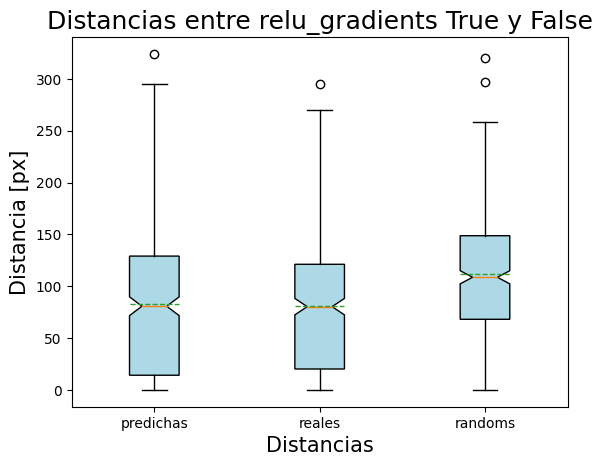

In [ ]:
# @title obtener distancias
distpredrealtrue = [3.92301869891762, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 221.02390871732723, 0.0, 61.775074336003655, 36.59104700543822, 130.90346245933566, 169.37304490691866, 79.03469919067223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.82218132266057, 179.61923589451013, 28.241560423296313, 8.932000559209651, 0.0, 187.7018214821144, 1.6916584604501348, 19.568555771384418, 63.77949121860972, 182.57038630808844, 0.0, 0.0, 81.62685107543639, 0.0, 0.0, 0.0, 61.38537190683774, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.267077750911454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.432599479574068, 0.0, 0.0, 0.0, 0.0, 120.04085415046238, 0.0, 0.0, 89.31997808568197, 0.0, 0.0, 0.0, 0.0, 85.41257808413914, 145.5948943917804, 0.0, 0.0, 0.0, 0.0, 0.0, 85.75223854647712, 0.0, 0.0, 90.77515567876358, 0.0, 151.7088543569266, 0.0, 0.0, 0.0, 47.85838771952869, 0.0, 0.0, 126.32370626899603, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 157.0664717873115, 58.23005412548494, 127.71490748105323, 52.50596424510277, 10.299338001561257, 32.87487963418164, 109.84761434680402, 66.83978934876572, 50.68962823732779, 79.96785551852382, 56.28599793470988, 55.61402014186586, 110.06406635221134, 35.60046239386367, 37.94048454182849, 40.726679180259865, 109.97990030637584, 158.4790204951153, 97.9953619022083, 10.34910015946395, 0.0, 0.0, 0.0, 0.0, 92.79933196869142, 0.0, 0.0, 144.6752252731629, 145.08768917541846, 0.0, 0.0, 13.458035302589531, 140.45152841714554, 0.0, 0.0, 53.2568387061048, 53.6049376462826, 0.0, 0.0, 0.0, 39.77951440060158, 99.03798204003651, 72.28434214659572, 7.25044552823639, 72.91577892931083, 83.11199270563682, 21.541278300106335, 0.0, 127.0762047036255, 36.11821278631584, 14.697790061896724, 110.77568177166172, 0.0, 109.58833100960263, 183.52407373965437, 17.434688115240437, 183.26438125219215, 94.10142510021285, 55.002029634434955, 19.970924685308734, 0.0, 3.971913072859142, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 62.58984425839762, 0.0, 0.0, 5.031344865271713, 0.0, 0.0, 0.0, 0.0, 4.420090789386557, 4.51749615801303, 97.20054495959809, 24.704590691986695, 0.0, 91.43327938045229, 0.0, 0.0, 0.0, 106.39819905881238, 0.0, 0.0, 0.0, 140.02768219720826, 0.0, 0.0, 6.9295490214408115, 0.0, 71.74865515208374, 0.0, 28.028348862209, 158.40722372649876, 18.538702680473396, 98.37078324547157, 100.61831840073184, 2.519416639111545, 0.0, 178.2249921372468, 126.86946322428602, 104.36062763975823, 0.0, 0.0, 176.41531410570957, 21.794288800522853, 122.48912554287458, 5.761354663370284, 87.00630035532886, 151.02299188238027, 71.09125229454715, 41.08669487415302, 12.063285153584024, 95.52853802561148, 0.0, 44.42038567714773, 0.0, 145.68544031674315, 0.0, 0.0, 197.96966913172858, 0.0, 0.0, 0.0, 0.0, 90.52433557261713, 0.0, 176.84131094493927, 0.0, 0.0, 260.93318377753474, 13.814422702961851, 74.60912961589877, 139.11923777062478, 131.17005914335613, 37.017296866197256, 140.71222544497036, 37.99611375379945, 0.0, 24.34557994051256, 126.35703097266729, 0.0, 54.1852593489525, 90.60353034206453, 20.494831855027606, 24.528323969268534, 91.27444260216146, 52.25673986005364, 8.306520098418488, 18.1353515295785, 87.36879144533135, 171.43290872079697, 175.72476148135155, 110.24054732842929, 24.768544315880728, 6.291741728386295, 270.24469213548554, 54.85326683464851, 116.66941546077132, 160.96892745481364, 148.5499529747472, 59.08513425987698, 138.50097362055345, 62.6626682738731, 211.75304873389302, 10.632842473364303, 112.23903305897693, 99.78558484006365, 0.32911043031801157, 180.61906677681003, 4.06188811479134, 0.0, 44.650628660191195, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 149.37571500806035, 94.54719088770874, 25.697439609286384, 0.0, 0.0, 1.1384776246319828, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.376605509205188, 0.0, 0.0, 0.0, 135.8738549761886, 0.0, 0.0, 98.198937512776, 0.0, 0.0, 59.51032423643265, 0.0, 0.0, 0.0, 0.0, 0.0, 53.302189232296726, 0.0, 0.0, 0.0, 68.7364905194268, 0.0, 111.14780966841737, 0.0, 90.76252003132112, 0.0, 0.0, 1.1034188552272273, 142.71287212605833, 169.72717500375654, 0.0, 0.0, 79.39512849248092, 0.0, 0.0, 0.0, 0.0, 107.77563966522617, 3.795511810368794, 0.0, 72.20250550007891, 0.0, 0.0, 0.0, 17.150336547889736, 189.90146279500033, 0.0, 0.0, 12.23686189716478, 77.27114347433562, 173.72195565312992, 10.623064294974652, 0.0, 135.97761177674317, 80.20092932414028, 124.23964276922433, 0.0, 0.0, 0.0, 138.19973869692487, 0.0, 3.8550921059235335, 92.80858747794062, 256.6634474491807, 21.841846555925258, 40.36593478879423, 167.1352200999885, 0.0, 116.83247274703025, 0.0, 0.0, 169.4080637653731, 125.19954078670023, 2.4526492380548532, 20.821126408195987, 0.0, 0.0, 2.585958190573456, 69.02543596514306, 0.0, 1.5422160947582655, 142.57108492251527, 0.0, 109.41522149929361, 88.24972548385114, 0.0, 84.5392695766998, 0.0, 0.0, 35.68555695642155, 0.0, 136.15479707099027, 0.0, 0.0, 175.72940270386175, 9.518448813297898, 4.459043677963693, 0.0, 8.307474607215738, 0.0]
distpredrandtrue = [80.5422925078607, 191.79761731672468, 67.98377936715191, 217.09424961099194, 176.45536782415013, 94.71477978791901, 17.58101807776794, 10.656720474721647, 91.59386205318087, 83.77684406813277, 16.6379224467354, 139.97356501238332, 120.66573087841289, 117.81851279965707, 264.3874514795686, 0.0, 132.5455437780972, 115.78592561927722, 0.0, 0.0, 154.67386989024396, 54.13315869636992, 47.54518410159502, 124.7066335001801, 186.6000531182341, 129.62185670837505, 5.24146399787518, 80.7683931031544, 187.7018214821144, 81.04110982471202, 30.76760321638094, 195.37163077896344, 207.8703303948283, 0.26710750760714763, 171.6840642939306, 19.111805552095067, 178.26424531687627, 7.591535667051227, 12.388353496161656, 66.4025397249195, 1.940808405227931, 13.241428708292643, 137.5728280435007, 173.20368576754512, 3.176803488797688, 123.31427577551699, 106.40945664588605, 115.5284557821486, 33.32420934851005, 47.584451600049675, 13.782935450331681, 3.0513431492042185, 33.76543398345767, 132.58596810278718, 12.549179520513414, 158.01624206430716, 74.09936912522548, 116.36680710093962, 93.78739390101573, 20.435524504896872, 3.6196441224644955, 106.37551347672108, 147.83463580638704, 178.0528368855294, 110.67892979738674, 115.35513151113382, 24.44277413192356, 3.2389422873851155, 202.38578384559307, 2.309662437038185, 161.66059677228594, 8.635975652862998, 114.4696744599028, 156.04225709226571, 39.76297919872484, 44.20222116973981, 229.3233898543043, 195.4558581939061, 138.2263986389821, 20.355942065623246, 79.13394080208693, 13.233702563364611, 12.907146081069584, 88.39505945487245, 60.61709683194394, 19.873355687867857, 25.555844685468564, 46.59235798377547, 94.52577568504053, 5.436750717411879, 69.6086106243389, 107.44152780550979, 0.6277064913798133, 128.6002611403288, 178.78793808411888, 107.38598096362281, 77.77441555028601, 77.07909655453133, 18.700121996352273, 1.5661703534886762, 123.92165658587011, 63.804692472376075, 104.02215601784114, 117.98116039268686, 246.99305139384862, 8.670064244325447, 45.84322741539101, 85.45967823599297, 89.19741557742731, 78.46035734021594, 63.85850446033811, 145.22478731768004, 79.37412687026428, 1.4583862712400406, 8.252556371661099, 103.80405946964297, 8.197320376920262, 132.64739985994478, 141.33465737025193, 14.511962312198918, 207.1889306725556, 86.57065215637672, 90.19643380610195, 37.777613342656046, 3.9552033800436246, 108.34795015741975, 172.02327907263526, 1.0916161610462758, 111.59710636341615, 116.10973110249047, 100.01912542142657, 130.49824118534832, 173.09959068903953, 199.88109484471278, 2.74261575600994, 47.47584035257541, 129.6906192758839, 86.91682957968665, 123.16438021479195, 90.66572819710095, 43.60186670316888, 66.77689281542641, 23.673039768312048, 96.87275064631962, 150.99792225406873, 145.10987238459228, 84.94258947710024, 180.98145255985992, 15.097979407498038, 203.64621577674674, 153.90976081380802, 141.3096386321076, 188.23994746817175, 92.26473282172643, 11.411773347327584, 43.28174708400539, 170.26037468764136, 16.557795265015862, 18.651481213850058, 67.56759298211361, 215.9950722427524, 12.430701992464112, 131.98382615704696, 152.97923575039013, 146.48080410132056, 9.11695729978032, 100.32855092619495, 1.4374919845296683, 109.70279130876351, 141.25397608495132, 169.71110582473978, 162.22328813792362, 13.706396224739668, 0.0, 13.369062603231129, 19.09904851947207, 21.729647960512157, 136.6451576926069, 94.04235675758461, 14.899930226782596, 89.1348001470248, 119.82577396877333, 92.81423023549807, 52.16870229659505, 72.36207636283842, 120.38138453871306, 2.1236464766764067, 57.71716003783299, 112.94648786177144, 154.35320825562187, 91.06331976652615, 84.99439020517713, 20.120021520491253, 6.917991754312981, 59.98759932287251, 100.72099127292937, 181.10714711239424, 14.440793291280857, 8.87126901781968, 25.730994453189776, 27.37289257064015, 129.48511849580146, 55.97825054555809, 43.95238660783025, 92.16744084827616, 78.36464321003979, 13.17233091653108, 9.562150468508355, 95.87595150755313, 125.79307709143181, 86.77020338635982, 55.64386615296485, 127.92926912279458, 41.21877044660236, 47.91169434157548, 93.88365509351664, 65.35553864371448, 120.36579482295063, 54.706846660412104, 153.41244027893705, 134.63671433161346, 5.214906134733426, 15.557199802112098, 60.35961163573983, 169.6164506070306, 80.33419372169332, 225.35495551437228, 45.015021334378304, 4.058187132452216, 68.82956101233049, 90.77912073911074, 14.469137041285295, 18.62524233244677, 85.72481559443108, 10.525413801318164, 60.59552517003822, 44.210384743736704, 54.59106429406626, 189.7947933521247, 4.509780450346771, 92.80915090544161, 58.93505497894762, 150.22730972968338, 43.17109677500616, 102.18852825407697, 0.8875545420517567, 0.0, 22.8305212045996, 104.5290005136553, 290.1413398784781, 113.06845763614504, 86.59833805118163, 113.7556892658068, 79.8602895402355, 74.24529174499673, 49.84732597385261, 124.65682241457516, 13.431322716428298, 93.62237593854482, 89.73110177297728, 163.6776510681816, 135.14670234413487, 21.37882886197118, 56.80189594860182, 220.9785954345629, 238.77138191695784, 110.05670235554761, 127.27763730483004, 14.122528783961284, 7.453050247559508, 125.24505108603846, 63.29622285037202, 146.8118652257177, 13.77709906720784, 65.01107767049737, 135.51755830975486, 48.26098071833444, 179.18160578743363, 31.4966514335449, 109.72057452855898, 241.36146389477082, 75.05135205140604, 95.89093689114172, 119.92242271065379, 84.12843708021894, 84.62576255228126, 59.10757628561665, 182.04499189018892, 110.78689496204794, 165.9061900086041, 1.936971153225042, 123.98277325146613, 1.3657612421153191, 47.988933440684164, 106.14312984130801, 0.4840220193990876, 40.87723703198432, 35.89018758992039, 108.68008855157744, 31.712066447244258, 143.73487484611834, 25.35608065850578, 68.56986867599937, 209.4923297659683, 111.33076908077639, 7.224841567189033, 7.2274134014998, 85.82615299757022, 24.866625164008866, 53.82910212660198, 13.263267467550914, 6.2494752757007745, 16.79199708884174, 21.644183625758657, 57.03346668057437, 28.491113149042828, 33.26294408242007, 15.77109581236346, 130.94563665565187, 2.1218571769820125, 190.11561414960886, 50.366742810803714, 2.099561273292742, 114.3246846037491, 14.29440893469165, 37.14186609120055, 114.5747729195942, 61.8696111571119, 4.807915853695694, 98.49711525989166, 56.01108745969105, 77.69209921752012, 85.20299866504061, 140.66644071056342, 6.751113118541639, 118.97381392980911, 8.054106432613564, 261.17580156604106, 5.051252935837688, 100.52712829067596, 21.095491981634233, 111.7234491124012, 77.88861306148533, 81.37784455669652, 66.41051664837798, 6.499166010210629, 190.45390632482395, 100.79006798331888, 44.96398116633136, 113.51872424359676, 7.397030152506693, 11.423151135075749, 82.9728714983175, 146.1777556111886, 2.836469968263864, 137.92443337628214, 179.71951311480547, 31.807742289998302, 54.187389891394695, 120.95797427829262, 74.53378206912632, 163.29018695992906, 62.04948222163707, 256.6634474491807, 160.9719805316058, 56.15259726440692, 74.96065773239344, 55.14010533427103, 245.44685540642078, 54.21563985008262, 29.75602199046146, 1.4954256902000427, 87.14914205909731, 3.0088827226512342, 190.35335776018283, 78.21497540570387, 171.76350236402962, 43.10327015034314, 20.52888560783236, 69.1719187601664, 10.35767624692406, 140.46840278691158, 9.531587187441183, 161.06902002836318, 6.859888233480643, 16.947933936910022, 64.66380756777632, 174.76494657132935, 6.1553975299799735, 32.154885054012574, 13.562287683095606, 136.73731185667467, 99.88227178297376, 56.73224136725772, 90.69251938785095, 102.27174854547034, 87.21893846999414, 5.848903376500729, 0.46987525794383, 3.8578945849068425]
distrealrandtrue = [83.37960001618114, 191.79761731672468, 67.98377936715191, 217.09424961099194, 176.45536782415013, 94.71477978791901, 17.58101807776794, 223.6070071790202, 91.59386205318087, 145.53091794084705, 50.841291270307316, 9.075513625814823, 64.43875928551599, 111.5143936461947, 264.3874514795686, 0.0, 132.5455437780972, 115.78592561927722, 0.0, 0.0, 154.67386989024396, 54.13315869636992, 47.54518410159502, 54.56535003078117, 17.37095010491965, 157.51719347754823, 3.701487956761049, 80.7683931031544, 0.0, 82.40355987554749, 26.234831744948092, 181.07638172243256, 27.330164887296633, 0.26710750760714763, 171.6840642939306, 78.08762133436284, 178.26424531687627, 7.591535667051227, 12.388353496161656, 9.893006283787923, 1.940808405227931, 13.241428708292643, 137.5728280435007, 173.20368576754512, 3.176803488797688, 123.31427577551699, 143.18645734587042, 115.5284557821486, 33.32420934851005, 47.584451600049675, 13.782935450331681, 3.0513431492042185, 33.76543398345767, 132.58596810278718, 12.549179520513414, 158.01624206430716, 74.09936912522548, 116.36680710093962, 93.78739390101573, 20.435524504896872, 3.8379689669454313, 106.37551347672108, 147.83463580638704, 178.0528368855294, 110.67892979738674, 8.635910544425418, 24.44277413192356, 3.2389422873851155, 159.16362997846116, 2.309662437038185, 161.66059677228594, 8.635975652862998, 114.4696744599028, 229.23789545885023, 145.46847475164336, 44.20222116973981, 229.3233898543043, 195.4558581939061, 138.2263986389821, 20.355942065623246, 110.0096266144739, 13.233702563364611, 12.907146081069584, 4.220859503514891, 60.61709683194394, 132.11049219727974, 25.555844685468564, 46.59235798377547, 94.52577568504053, 52.232081945134475, 69.6086106243389, 107.44152780550979, 126.62388446568173, 128.6002611403288, 178.78793808411888, 107.38598096362281, 77.77441555028601, 77.07909655453133, 18.700121996352273, 1.5661703534886762, 124.31664061533692, 20.100041340625452, 42.39518218043728, 114.56965784172975, 255.9324764895796, 29.802096987684006, 131.67870409637953, 21.443287434697986, 39.73453752588051, 9.587133540525143, 35.736354603692334, 102.99636104202304, 96.00117641595469, 34.92998540301169, 31.79042739318045, 69.23459443930064, 116.75479644078007, 249.7352272004265, 45.52316917184957, 24.83722495414065, 207.1889306725556, 86.57065215637672, 90.19643380610195, 37.777613342656046, 89.20880288160497, 108.34795015741975, 172.02327907263526, 145.765066346221, 233.02401878311545, 116.10973110249047, 100.01912542142657, 132.00459577857336, 72.3392265801257, 199.88109484471278, 2.74261575600994, 7.181207786161909, 134.99676405333184, 86.91682957968665, 123.16438021479195, 90.66572819710095, 3.880895252158239, 137.6627641986781, 87.66726331812683, 90.81912228083567, 214.27600075129683, 111.73941930260877, 78.82639448554897, 180.98145255985992, 117.9532712761221, 171.33687876259384, 154.256212256806, 167.51064290931214, 188.23994746817175, 35.84933072216781, 177.88174133247225, 25.855996603734262, 13.436123498855375, 97.12761682846606, 69.59429699738249, 68.4919523207187, 215.9950722427524, 9.73302873300217, 131.98382615704696, 152.97923575039013, 146.48080410132056, 9.11695729978032, 100.32855092619495, 1.4374919845296683, 109.70279130876351, 141.25397608495132, 169.71110582473978, 162.22328813792362, 74.81621577479136, 0.0, 13.369062603231129, 16.248113457043807, 21.729647960512157, 136.6451576926069, 94.04235675758461, 14.899930226782596, 87.44778798452714, 116.58811125215549, 40.716343738715445, 75.11985166340698, 72.36207636283842, 81.48549096830855, 2.1236464766764067, 57.71716003783299, 112.94648786177144, 118.84120385771674, 91.06331976652615, 84.99439020517713, 20.120021520491253, 141.04834717675678, 59.98759932287251, 100.72099127292937, 177.9560229284403, 14.440793291280857, 79.72279213238009, 25.730994453189776, 26.52224674585833, 204.19671524856787, 65.6600612260184, 65.34079751363477, 95.71140692039572, 77.29215054147012, 13.17233091653108, 187.2292556414323, 36.47767439700364, 159.5673131991117, 86.77020338635982, 55.64386615296485, 114.36554688296975, 62.86219007741763, 159.78304753121864, 97.86798087215348, 45.89523545029169, 84.82281767414538, 113.88170594876142, 114.30386576574824, 143.6960556233442, 90.43800388904052, 15.557199802112098, 104.11741703958569, 169.6164506070306, 79.07088460159392, 225.35495551437228, 45.015021334378304, 194.47486756020473, 68.82956101233049, 90.77912073911074, 14.469137041285295, 18.62524233244677, 149.50086633051737, 10.525413801318164, 146.2674065966625, 44.210384743736704, 54.59106429406626, 80.69646242408368, 9.348437999257502, 28.785384690304834, 182.10147171227868, 129.5298077189338, 6.291166459342428, 40.9881285409094, 37.22437823511013, 0.0, 2.351126264046096, 22.219117213252293, 290.1413398784781, 100.80244010279795, 165.36839643724136, 109.39581855218047, 104.04836557657104, 17.57556324015584, 2.6752476686188675, 125.44734210796274, 31.440793480858964, 9.271320844771328, 95.66886728454828, 12.202665637705918, 165.53659495454878, 12.251990654855549, 59.68084805043673, 89.01426063386046, 193.64132541024114, 10.026515395876308, 227.66317037816867, 146.7961699635824, 64.30871234599284, 214.28869964945093, 0.7728675044827802, 67.65310836948953, 8.285848613790753, 53.83464174411591, 47.62646459379734, 48.4811031797031, 4.6553979432798105, 28.275319226676878, 109.72057452855898, 197.10625444084923, 75.05135205140604, 95.89093689114172, 119.92242271065379, 84.12843708021894, 84.62576255228126, 59.10757628561665, 143.58563886574623, 16.257740994442155, 140.24639404069887, 1.936971153225042, 123.98277325146613, 1.7885046573123637, 47.988933440684164, 106.14312984130801, 0.4840220193990876, 40.87723703198432, 35.89018758992039, 108.68008855157744, 31.712066447244258, 150.03131769662855, 25.35608065850578, 68.56986867599937, 209.4923297659683, 134.03340558628526, 7.224841567189033, 7.2274134014998, 181.12975588976605, 24.866625164008866, 53.82910212660198, 46.286666509017586, 6.2494752757007745, 16.79199708884174, 21.644183625758657, 57.03346668057437, 28.491113149042828, 40.00193396310906, 15.77109581236346, 130.94563665565187, 2.1218571769820125, 257.4737488635173, 50.366742810803714, 111.57109240860046, 114.3246846037491, 92.21317780950689, 37.14186609120055, 114.5747729195942, 62.75342677235621, 144.99185869914044, 79.50412205316734, 56.01108745969105, 77.69209921752012, 69.44412330013094, 140.66644071056342, 6.751113118541639, 118.97381392980911, 8.054106432613564, 207.30955306574253, 8.316331951344536, 100.52712829067596, 57.873304212538265, 111.7234491124012, 77.88861306148533, 81.37784455669652, 65.3079085020031, 185.89052646431577, 190.45390632482395, 100.79006798331888, 56.7849166141002, 39.68119016742844, 168.86336941852818, 1.0239463264835371, 82.9728714983175, 125.66906426313017, 79.74709093212935, 134.53048969581224, 179.71951311480547, 31.807742289998302, 54.187389891394695, 204.44898810691745, 74.53378206912632, 167.09000737379355, 154.83342123257518, 0.0, 171.98531613697443, 85.85990030412098, 92.32681688308892, 55.14010533427103, 179.59340823394575, 54.21563985008262, 29.75602199046146, 168.11694561055685, 84.36332566274434, 4.418149051063025, 171.4840002934721, 78.21497540570387, 171.76350236402962, 44.47012810466497, 86.98397478547464, 69.1719187601664, 11.342632079508585, 12.60355100992302, 9.531587187441183, 103.1090166951013, 82.13468430807272, 16.947933936910022, 143.82948893112766, 174.76494657132935, 6.1553975299799735, 3.541922625419196, 13.562287683095606, 16.64067140740688, 99.88227178297376, 56.73224136725772, 86.26391573065118, 109.55470754857737, 85.0224533858733, 5.848903376500729, 8.559219246200417, 3.8578945849068425]

distpredrealfalse = [58.14939848461404, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 110.36410598603942, 0.0, 42.500060995836, 145.1970234573082, 117.37291055163712, 198.2904432627562, 97.4562782107556, 0.0, 0.0, 0.0, 0.0, 172.07830597956135, 0.0, 0.0, 0.0, 0.0, 97.71577350746985, 128.40650928582355, 121.94881299874861, 75.41366758625404, 0.0, 75.93401021102143, 102.33196254601688, 4.678996120474906, 130.8299189899396, 29.722686242363157, 0.0, 0.0, 136.391544604806, 0.0, 0.0, 0.0, 9.801028546185995, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.21399725769701, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 320.49676888886563, 0.0, 0.0, 0.0, 0.0, 128.32548680824812, 0.0, 0.0, 67.63613516835838, 0.0, 0.0, 0.0, 0.0, 100.47677692332043, 44.63646345712552, 0.0, 0.0, 0.0, 0.0, 0.0, 38.63458198657925, 0.0, 0.0, 47.587249083939135, 0.0, 115.50102045212847, 0.0, 0.0, 0.0, 119.5921475268171, 0.0, 0.0, 86.63511999434566, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.57961180573271, 56.47476834351572, 41.28870465511738, 130.74112351286777, 122.14867710225137, 117.25288906678806, 75.1661862675979, 80.92880163794307, 32.04085678176044, 109.52232079973373, 190.6508967282647, 68.20971701100527, 50.25757981347049, 72.1938083771892, 114.92264313393535, 120.76092988918268, 169.259744761375, 47.42250680484478, 95.48436699191979, 174.01642820368164, 0.0, 0.0, 0.0, 0.0, 93.30192567554987, 0.0, 0.0, 66.83118248697612, 124.41430289548117, 0.0, 0.0, 74.98354607065616, 21.461995812174823, 0.0, 0.0, 106.47310885715001, 64.54322004280603, 0.0, 0.0, 0.0, 38.60960638133705, 8.775558717234052, 74.15116328244866, 158.59887814947083, 51.41984788241779, 133.20735489197978, 128.60923650304244, 0.0, 204.9714181780189, 54.254790840862505, 195.2615329755141, 184.10221674216177, 0.0, 167.69657775445526, 90.65597843344817, 114.16323137347176, 27.516533456004037, 54.83752821449896, 178.55036115139188, 46.2851911475168, 0.0, 138.06666026864175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.11526363206639, 219.38075573474285, 0.0, 153.04477730573572, 0.0, 0.0, 0.0, 0.0, 178.8819096457694, 131.29705673641604, 213.06777795467767, 145.39431136043882, 0.0, 0.0, 0.0, 0.0, 65.31035581356164, 181.22934294736356, 0.0, 0.0, 0.0, 128.50194387770975, 0.0, 0.0, 68.27890399263404, 0.0, 79.40472166770907, 0.0, 108.81276143203783, 189.2289840172479, 205.74763381283117, 66.86437864896273, 111.73813565056821, 80.31022761115922, 0.0, 126.16259873603524, 81.0225872246204, 65.74225273952237, 0.0, 0.0, 126.17188303054208, 98.32008686645793, 43.372807099653826, 103.39277872446385, 86.27508789974735, 162.01464252586368, 77.257315398289, 86.59775743926036, 63.803809807206996, 184.77768755308747, 0.0, 45.777231549141284, 0.0, 157.34968956603214, 0.0, 0.0, 55.44322919242009, 0.0, 0.0, 0.0, 0.0, 48.935847329810954, 0.0, 92.45119334453398, 0.0, 0.0, 157.89042531306026, 119.50929622250466, 76.73032513268187, 74.80749752347555, 141.57101810243617, 114.23095055587281, 275.7092289563083, 222.2148038292038, 0.0, 24.905112878860773, 134.70930934944911, 60.19084135401862, 53.67324943394505, 130.98837166866429, 148.09933119326593, 175.27402955653764, 116.28540613339314, 212.87293857913417, 93.0809000305825, 125.81250677315943, 110.80753729253586, 187.16040771965163, 176.516141870878, 85.62738779546163, 65.22730316541386, 186.44384091203872, 104.78811533888991, 179.3163915793729, 249.30728524047797, 177.70110027587734, 216.4682367291039, 89.55090286985052, 81.30768329141313, 107.2074242993839, 160.8000887869725, 91.3840221087115, 75.3164957768134, 160.4610303887271, 14.83645306761729, 62.65304435071117, 209.02194881006056, 0.0, 109.85798976877626, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 182.79728164586618, 120.22815951233916, 184.17713996551382, 0.0, 0.0, 90.9174750674478, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 108.88597218505595, 0.0, 0.0, 0.0, 107.82277841001958, 0.0, 0.0, 47.63634263955319, 0.0, 0.0, 47.92215568319852, 0.0, 0.0, 0.0, 0.0, 0.0, 143.23233039868455, 0.0, 0.0, 0.0, 96.4162820838849, 0.0, 37.64863404138519, 0.0, 138.26640910877148, 0.0, 0.0, 116.10709694696473, 163.34216993366832, 84.5876418319602, 0.0, 0.0, 25.403504891047543, 0.0, 0.0, 0.0, 0.0, 89.99425293529457, 57.99023864234842, 0.0, 151.97864794707687, 0.0, 0.0, 0.0, 175.60949225792024, 36.866193722057716, 0.0, 0.0, 13.89707446263761, 123.9036338034509, 110.58571662428766, 105.04279744456854, 0.0, 57.92563303729419, 98.66656724390525, 217.66967584133377, 0.0, 0.0, 0.0, 49.88396216270889, 0.0, 62.88273524334343, 82.86057923914697, 191.01063015723915, 92.36498792661412, 59.69723464938778, 53.65403360067933, 0.0, 6.137877476461502, 0.0, 0.0, 167.1246715945432, 83.55158831114802, 24.85536555282082, 196.24434415652993, 0.0, 0.0, 13.516320708490447, 123.40896355633444, 0.0, 89.8977114685347, 84.25861092569612, 0.0, 163.3448207452892, 110.29340777059413, 0.0, 195.86625640026824, 0.0, 0.0, 56.88073575750124, 0.0, 37.099665099652775, 0.0, 0.0, 57.756340741339436, 112.30340768846922, 4.780504149835046, 0.0, 59.65213112350001, 0.0]
distpredrandfalse = [212.50678415672215, 150.44949588897168, 231.4873155908312, 118.57227887188193, 105.48046415459751, 135.59800721489506, 22.17935050300807, 202.49436462725723, 68.95650971695639, 113.05112442836636, 150.67166137856148, 126.44665125250721, 182.16717885774605, 107.97612063745201, 0.0, 0.0, 183.91874270370897, 148.70150649403692, 243.27287015730406, 159.42774565602602, 53.42141526771267, 63.142928422688314, 54.04552558368642, 194.39816222621988, 69.94459491297891, 82.57936217817952, 106.80488001278384, 107.44195628768838, 109.8756234170485, 137.40134444078822, 133.11167009662975, 177.8970601375691, 100.2246228745762, 121.51409083846443, 92.49577818790023, 137.73712953924138, 134.1172315759942, 64.43526794514709, 89.7880987779718, 102.94292086974342, 57.13493022685902, 130.51444015196634, 158.78612716122575, 108.82878644108614, 45.629883756504896, 164.93683573926066, 129.24660467000444, 158.47047891010598, 58.0108222048693, 131.19208099070318, 161.73844074990262, 100.50378492779892, 45.66319267316246, 150.38813259674384, 171.23288084358626, 100.3100470393463, 117.60012130780846, 155.949505366878, 139.2718863937849, 127.23629068774468, 0.0, 70.98524330555456, 230.31445329868868, 157.41803262398108, 251.3365994206514, 128.60345446607047, 161.438819334338, 55.634620717252865, 35.47416391004073, 194.91314065704717, 93.34508338676466, 241.5686204654511, 119.49123057947328, 187.1711815808584, 232.87340029439537, 144.3083254956167, 217.11185890340772, 239.9397722780337, 90.77409243216341, 83.24820612839586, 53.57104397343785, 78.90306056354515, 70.1758054039267, 68.33393797502005, 168.2091087484584, 83.22565127301554, 38.8715698313532, 154.2742050303481, 154.3686262439531, 92.85895090986405, 108.86810600584386, 86.01716142655222, 99.84530749694828, 0.0, 194.79447003545036, 109.6276322051914, 89.6521563723095, 48.47323833311472, 153.90479100813573, 39.09212043817939, 123.7943628574256, 77.97578554616162, 95.42089005204002, 184.67862260845925, 65.38273428004317, 77.58251794707054, 15.351162615429443, 157.80687878104973, 148.37015904864575, 0.0, 176.89554727525544, 53.18318144076207, 14.41912701325461, 96.58563858742379, 159.51489213830055, 92.34404398698693, 220.11324102146415, 113.07013213141947, 84.72535355038362, 72.93795541627645, 84.72549212194868, 118.22598346532067, 78.50155481290611, 97.45920997450943, 36.204931830746126, 181.278287300693, 140.35565100792516, 47.303379645025764, 116.5407872945661, 182.60283193028695, 74.01663142876211, 8.499548337214542, 169.4437812260955, 128.88732651245743, 109.45820447950553, 140.7196487545745, 197.52107371240163, 80.42923806741504, 45.45208089367651, 36.34892955652854, 132.66422802614179, 61.99077259067328, 57.37445638391235, 153.0363396896725, 75.24361220676853, 28.562341831527153, 150.57390336795012, 90.14679225859892, 38.67723017718016, 122.16524696515752, 201.81664520381338, 101.49997275779778, 148.29846455638764, 89.66290296248927, 96.64496305805847, 192.10832717640238, 156.03157304258914, 121.27908012830261, 211.86676667347274, 148.58678828752778, 228.75108645071876, 101.87177035972918, 241.50107887141962, 251.88659732154164, 244.17968233119214, 0.0, 144.5136199482545, 163.22287560401378, 154.96570557672317, 85.21988244077214, 142.08263556402687, 75.17482526592357, 128.849398745638, 113.8365677425383, 103.16924129104393, 53.39884173850774, 116.23911561883084, 183.5973874200032, 179.66632927631724, 177.88980206959513, 214.15824365603623, 318.2445148985602, 1.2931340388391313, 119.92488668698493, 147.83729136723534, 54.586609708044946, 93.94648767599419, 74.50327931052564, 36.21605285346262, 88.38532389743273, 58.448580080851734, 102.14724889296264, 144.39983442909485, 85.79588723580316, 40.283106291119914, 161.17869284759223, 60.34444948384184, 116.51688491599175, 30.39149566667171, 65.57297253083068, 222.3725453229814, 189.44151791917108, 321.31639502848145, 115.76792911590687, 50.278378364302306, 163.84317809081244, 161.77439936603844, 112.50279454907991, 124.61476252443833, 120.27527707916293, 11.072861000283636, 51.60570593851396, 70.50772047514009, 174.62486724736272, 80.70801095440649, 29.88386116828327, 108.72619929726044, 192.47971692626177, 22.257796692035555, 59.59870987242698, 101.7986942931514, 99.05328864066195, 113.93330695424932, 80.9989376744779, 237.61662271159253, 32.75685060433345, 116.75765130663086, 67.01895373790575, 76.92622944185057, 94.83448245133336, 64.89919759215572, 120.56505774419321, 167.35568320276226, 137.40051566920164, 108.18625266366035, 191.1919292273333, 110.95983744946693, 102.3085840572627, 108.81401080516753, 198.63882867725624, 52.69960905825451, 82.12311096121275, 159.53880459473243, 175.7797036170483, 178.35573874959223, 241.36547573130727, 235.85489014213465, 118.08428501760037, 36.35962216218728, 57.73628758900339, 0.04785883751495818, 116.31881993363629, 145.67161512908444, 128.69192705733664, 42.22981289466477, 75.2061345235013, 31.331559982470534, 73.5762571783857, 68.29451066192497, 49.19067313717083, 54.472276345779854, 124.53632537001232, 115.5645687041672, 115.84558786703944, 138.7302665629259, 67.99750385619949, 132.73805594973365, 94.36264034679348, 216.4682367291039, 131.28448565308207, 120.48865613793167, 178.4899768704296, 56.17663192149401, 64.757135902087, 84.7272879583001, 155.01308407147505, 76.49334342975797, 71.6191333697267, 94.83038311271658, 46.64704794620311, 198.4612254511146, 118.02709960755149, 130.12338650674198, 58.58625755323511, 96.06105916733947, 209.549849777177, 145.22334562498182, 124.12236618804619, 98.72444183231696, 42.57992500543177, 64.2902141368929, 127.77807001617307, 104.43382648392168, 47.14563040095253, 122.67516574719114, 95.25428477380258, 81.81919419274695, 107.987996311226, 68.90302278120151, 109.33257098448718, 81.76473550453274, 191.95933947202624, 59.902674733608556, 178.87887384739997, 6.436235505180167, 132.23125917903667, 123.67790210509091, 56.15459359956127, 83.8507105918498, 63.26664998480646, 4.309485432232267, 152.96373667797684, 94.36560935286023, 105.72271589234624, 98.89962125705752, 56.21468227968161, 13.463329219602782, 69.60748184910118, 54.46363666661812, 0.0, 148.9993797499331, 127.54057339160619, 200.33762885797483, 126.45620818162635, 223.71540242081974, 121.44671457008815, 70.25645427765662, 56.76927177156984, 133.3092188495937, 100.4754667265786, 59.812298198636555, 188.39103627787114, 77.28327912882551, 215.31736518491974, 83.45219526688687, 24.05492647960986, 145.79106288500853, 94.07168684674836, 14.822179653587977, 194.72623690604965, 215.11006297367211, 0.0, 85.58787472887734, 147.91857288159065, 175.56083663620555, 119.48294407925027, 118.66659729990509, 244.69370620093082, 108.16777593404173, 179.3334174440678, 62.75461133442224, 169.65306900568, 76.0068430051443, 150.14753867221268, 15.579294148204282, 270.9722406473479, 67.24309504860507, 163.08896471057326, 209.4783713652618, 202.24637697464055, 90.47025754823485, 130.99509444440315, 138.01860382994653, 106.63736964603818, 109.77055311978485, 49.92173180904732, 74.21219625515477, 65.71367418155414, 192.35508412051968, 64.07646940188093, 78.8964334952452, 115.2300559443182, 126.99457211848808, 40.27554595092463, 79.08865991433159, 96.41284792104253, 207.6788555941665, 29.036992352993572, 77.68135380351497, 149.4159813916374, 146.78845136140245, 59.90180909819092, 92.00213739998661, 216.06425436351955, 96.660053956871, 80.28397263004328, 180.14423092832322, 134.78401798728297, 83.29547829556553, 153.24006717887028, 176.80572744036778, 72.52434104262197, 75.52246133778948, 100.06204962367775, 80.02998922369729, 23.326903883238835, 80.7744251978494, 128.3582629302318, 43.490828689337434, 177.41227521672934]
distrealrandfalse = [177.98885149005818, 150.44949588897168, 231.4873155908312, 118.57227887188193, 105.48046415459751, 135.59800721489506, 22.17935050300807, 161.31494075926688, 68.95650971695639, 155.43981233015714, 98.26318520567915, 106.44887061246082, 129.4158723599536, 41.141694755135156, 0.0, 0.0, 183.91874270370897, 148.70150649403692, 161.36358668011022, 159.42774565602602, 53.42141526771267, 63.142928422688314, 54.04552558368642, 258.5413443034655, 133.39803076275072, 103.98222863683218, 77.58701729049042, 107.44195628768838, 177.91198382641633, 200.62853833411148, 132.57979483322876, 75.4661689696801, 111.79065940964283, 121.51409083846443, 92.49577818790023, 56.332375687880756, 134.1172315759942, 64.43526794514709, 89.7880987779718, 93.16359736476527, 57.13493022685902, 130.51444015196634, 158.78612716122575, 108.82878644108614, 45.629883756504896, 164.93683573926066, 136.12438445313, 158.47047891010598, 58.0108222048693, 131.19208099070318, 161.73844074990262, 100.50378492779892, 45.66319267316246, 150.38813259674384, 171.23288084358626, 100.3100470393463, 117.60012130780846, 155.949505366878, 139.2718863937849, 127.23629068774468, 320.49676888886563, 70.98524330555456, 230.31445329868868, 157.41803262398108, 251.3365994206514, 114.77867797059078, 161.438819334338, 55.634620717252865, 42.34480877814941, 194.91314065704717, 93.34508338676466, 241.5686204654511, 119.49123057947328, 114.63229035014417, 271.2615754820435, 144.3083254956167, 217.11185890340772, 239.9397722780337, 90.77409243216341, 83.24820612839586, 92.20253591411361, 78.90306056354515, 70.1758054039267, 114.0826779815356, 168.2091087484584, 125.2589409321334, 38.8715698313532, 154.2742050303481, 154.3686262439531, 53.25915478889421, 108.86810600584386, 86.01716142655222, 99.00847992790688, 0.0, 194.79447003545036, 109.6276322051914, 89.6521563723095, 48.47323833311472, 153.90479100813573, 39.09212043817939, 101.58961753726268, 105.32935830863575, 70.37570316496515, 54.380510922062584, 164.97777524676525, 133.26555260634103, 68.98606407987228, 77.00058651364425, 125.09314876075318, 109.52232079973373, 15.856055451063964, 32.411593384193715, 50.91788102174426, 71.85683380015664, 192.78803201377724, 87.19893089950467, 62.640840303761735, 107.99864490366548, 88.58393306279697, 154.9337560463816, 84.72549212194868, 118.22598346532067, 78.50155481290611, 97.45920997450943, 110.91726395501617, 181.278287300693, 140.35565100792516, 97.42001613699317, 86.16994461065741, 182.60283193028695, 74.01663142876211, 73.98939432017109, 157.12350736197112, 128.88732651245743, 109.45820447950553, 37.690474525986644, 133.14327097315348, 80.42923806741504, 45.45208089367651, 36.34892955652854, 100.6318224061223, 69.62840279011137, 84.53148357405864, 50.657428118646735, 47.356508089293136, 140.1204458394858, 75.42761910915516, 90.14679225859892, 243.64252787098164, 132.80977039854108, 90.03990446302811, 94.88109651059091, 148.29846455638764, 117.33764805945806, 118.40393350687769, 117.89882644540037, 182.6353009137194, 69.33115825553587, 42.25404288797274, 185.61497003261073, 228.75108645071876, 219.71634026433588, 241.50107887141962, 251.88659732154164, 244.17968233119214, 0.0, 144.5136199482545, 163.22287560401378, 154.96570557672317, 85.21988244077214, 142.08263556402687, 75.17482526592357, 164.02111300176105, 324.00738147323705, 103.16924129104393, 202.0446954138846, 116.23911561883084, 183.5973874200032, 179.66632927631724, 177.88980206959513, 36.65763013871934, 192.29407257994464, 214.26278667595517, 36.51749947988763, 147.83729136723534, 54.586609708044946, 93.94648767599419, 74.50327931052564, 100.30191163629678, 94.57796565158073, 58.448580080851734, 102.14724889296264, 144.39983442909485, 195.89975084610484, 40.283106291119914, 161.17869284759223, 71.10047022228775, 116.51688491599175, 60.29306283051819, 65.57297253083068, 118.60728215874612, 127.48368573668526, 119.02821989583798, 125.06812099423189, 162.01300483531773, 110.21363879212595, 161.77439936603844, 189.88484802658252, 48.63417508512627, 55.671443760289534, 11.072861000283636, 51.60570593851396, 184.42575428506672, 77.11685583157022, 42.44526665359207, 93.49399709101388, 69.38312672675079, 61.03115700227998, 55.02183338446957, 110.89731404041729, 57.324207058321804, 119.08185224177906, 113.93330695424932, 36.517725749828124, 237.61662271159253, 125.9667700971179, 116.75765130663086, 67.01895373790575, 90.25767712496568, 94.83448245133336, 64.89919759215572, 120.56505774419321, 167.35568320276226, 173.44904232203206, 108.18625266366035, 104.81567885275652, 110.95983744946693, 102.3085840572627, 76.2546878919042, 104.32213113191675, 121.64860475377797, 145.43997988301234, 40.537812105531486, 149.2828837840225, 235.81225585500508, 45.18686743180164, 235.85489014213465, 98.27019930754092, 170.66757192374757, 112.78034566108802, 53.70522704963116, 61.645705314881695, 220.05081316793627, 46.83403103610715, 97.97111800148123, 166.78908826779454, 89.32917141011056, 191.14619587401694, 126.25576264504218, 175.10010358866705, 136.7086899183706, 195.5129163775735, 52.607837650567745, 75.61013155153076, 83.51272036202622, 134.13649883018155, 128.83190238555582, 271.879034268601, 0.0, 126.07455756642388, 63.472889014839495, 128.59714517048883, 174.65425372490853, 71.36477357358947, 148.86083135401003, 71.2777261472117, 64.42527375205255, 113.40880666858546, 148.56665128332602, 46.64704794620311, 91.54915340533276, 118.02709960755149, 130.12338650674198, 58.58625755323511, 96.06105916733947, 209.549849777177, 145.22334562498182, 67.19122777794118, 42.40372589220997, 208.95869800796592, 64.2902141368929, 127.77807001617307, 86.75844198129636, 47.14563040095253, 122.67516574719114, 95.25428477380258, 81.81919419274695, 107.987996311226, 68.90302278120151, 109.33257098448718, 190.51845390535496, 191.95933947202624, 59.902674733608556, 178.87887384739997, 110.75674497183027, 132.23125917903667, 123.67790210509091, 82.59124562434128, 83.8507105918498, 63.26664998480646, 47.08662879529743, 152.96373667797684, 94.36560935286023, 105.72271589234624, 98.89962125705752, 56.21468227968161, 151.3857877267783, 69.60748184910118, 54.46363666661812, 0.0, 56.46406078570989, 127.54057339160619, 177.85475124295868, 126.45620818162635, 129.948552583513, 121.44671457008815, 70.25645427765662, 59.86801229991048, 43.58857061387946, 81.90187659511098, 59.812298198636555, 188.39103627787114, 69.03458033425366, 215.31736518491974, 83.45219526688687, 24.05492647960986, 145.79106288500853, 83.04870882628937, 51.18909537913096, 194.72623690604965, 107.420518283254, 0.0, 85.58787472887734, 147.91857288159065, 214.12626047019594, 143.99949117237026, 118.66659729990509, 244.69370620093082, 95.20573129879273, 110.07078595826019, 156.43425083369803, 140.92841916334334, 76.0068430051443, 101.50318170466933, 89.44085731053323, 54.00288273664375, 67.24309504860507, 163.08896471057326, 209.4783713652618, 163.99828902146834, 90.47025754823485, 161.82204660386188, 181.07687832232443, 91.34475493908319, 45.86111659166711, 59.74039037923571, 35.40770457693866, 65.71367418155414, 193.96512153232877, 64.07646940188093, 78.8964334952452, 74.59296925953548, 81.34967303592587, 46.626856608921194, 210.28782029335943, 96.41284792104253, 207.6788555941665, 37.144026639535625, 85.11563728949135, 149.4159813916374, 133.44918752300552, 123.94169864734714, 92.00213739998661, 57.65839580104618, 205.44568379706172, 80.28397263004328, 91.81222839017126, 134.78401798728297, 83.29547829556553, 96.47426884957343, 176.80572744036778, 81.90819588714393, 75.52246133778948, 100.06204962367775, 135.34114003890429, 113.99871703277685, 78.57901155980088, 128.3582629302318, 65.24678113282562, 177.41227521672934]

distrealtruefalse = [108.68982414401948, 191.79761731672468, 189.01453728792578, 116.95354337944423, 172.22587053878806, 68.63201390275697, 87.76094937194478, 205.58918776000382, 1.5082698461221231, 7.1254373066796015, 8.766873815215833, 5.626922174132429, 166.25641099678825, 96.10916258394894, 264.3874514795686, 0.0, 73.18644415920939, 182.5605108342803, 293.95433239015955, 159.42774565602602, 79.13647352559222, 7.675994128214257, 86.58298550542335, 82.71388318047059, 13.026753284410749, 150.54071635223656, 6.527732975791247, 14.821715092871898, 263.6338986610837, 7.40471606912921, 19.734967383698777, 85.13928282378821, 3.577308823616737, 4.551438879340713, 92.54093798082457, 81.17621554584233, 63.06865178608231, 151.93346115572524, 33.489901576247235, 57.982410934379395, 95.5897846242013, 5.532249638392728, 129.5120784509566, 5.714713878762754, 154.8955118501815, 2.1969504919302056, 152.6950709285143, 98.88475201212476, 8.962381721110194, 11.322464285201457, 134.61012824038522, 70.5798255564371, 3.0606174922241207, 117.72152249228546, 1.8864987262960846, 7.031991939312591, 82.50100208448268, 8.150257540385894, 17.057145854937836, 10.872454243047372, 140.63913156384692, 33.56268315969328, 25.37697757254456, 232.75256982104256, 131.99000126678723, 162.17782674718603, 148.22723424632593, 108.01936381871002, 6.361899498397823, 215.84842403217058, 103.27595679631096, 24.26654098776194, 32.87774498073016, 24.974227659854428, 5.7921764659501545, 8.919601162450395, 71.94702200646482, 179.34025993784738, 173.01758251940427, 169.1272716096573, 13.943070739797266, 13.92102594538825, 7.855472093150012, 108.80943388782882, 142.67894540083563, 55.62341718168809, 106.45629946274835, 10.507198805563354, 18.29754091773594, 2.6500522918338345, 109.51765236642677, 148.55214645776195, 128.80409415092896, 219.2305223323638, 77.59161047084096, 120.48074847988426, 86.41810168146756, 150.3285502477596, 20.98319713630055, 72.91780796362885, 19.20353531254975, 82.47247825942196, 70.3373262952247, 29.036995293924388, 5.706830662239872, 14.384511692358073, 92.58220677835173, 5.456090539021283, 66.48965569955281, 126.61682523818085, 139.35582981129096, 72.41350306624447, 150.43607010593132, 77.92987356309538, 103.48871093520661, 75.67507568576693, 103.78288479315667, 126.14877785538332, 3.9336621860875547, 100.79767504202611, 133.1462005019249, 89.18290399758034, 83.33391089246143, 73.92524361971563, 51.740446908797345, 34.486154661389385, 149.21991434818463, 9.974218319794497, 234.50607177293517, 199.2420486203529, 94.21281266609901, 131.2177994596022, 39.134165305971244, 0.0, 14.75586954350353, 129.05605123794632, 118.50349337091663, 94.97712718548587, 26.22672405242345, 121.68273912061164, 0.7966064510908386, 10.008062840707156, 4.756290879198041, 127.30623101810434, 118.24008988310707, 56.62898703544941, 134.13638509443456, 61.79738085058558, 86.7296272021472, 63.2657468946349, 150.26300431098565, 138.49092382519916, 209.88713872565856, 127.46706927146843, 129.68522687585306, 35.697787644526485, 181.97325029377515, 4.003180243218338, 57.64345601567054, 17.99078034709967, 295.38881916642873, 82.4102739066847, 0.0, 140.42810010645084, 114.30596229270685, 169.75739445950776, 103.1489713868665, 117.48019780097559, 74.01731032684526, 128.3122778480687, 158.13884857911285, 104.12504477910855, 52.333441229549614, 324.00738147323705, 152.94604486409347, 164.5380584547951, 91.26889850521617, 5.087295791388347, 84.98479512353585, 7.013468342667256, 157.88945198437125, 82.60800775537562, 69.68948550219676, 93.08673419621587, 106.94184650530887, 131.83742348154087, 1.2584527994150847, 99.68039302790692, 128.75061939608335, 132.05157481499162, 5.690204833633839, 7.093834196644908, 23.299685583266527, 248.30077408646022, 80.37493351445728, 85.15911558029563, 3.992422698839387, 58.42814860747215, 3.63239675365745, 57.75111377954276, 7.326799596615059, 206.55839880118975, 144.46561125522905, 82.47420424441178, 3.456812015312787, 167.342328888303, 4.6686196758832645, 231.08798662387488, 10.756168468806184, 125.51018018262653, 37.76554686218866, 99.19250986907427, 142.9211675651794, 9.576358829060709, 163.51245477797897, 146.93083154780507, 91.41718689242246, 119.82739344489663, 159.14102905539545, 116.65482868819757, 104.23035406538581, 217.2578738300844, 9.321285232543284, 15.372984290419664, 136.53030955310197, 142.32795597040183, 0.0, 4.457996384531856, 182.8882766778813, 109.45687407552536, 2.8522524863174175, 43.93519355579092, 165.02093474843235, 120.61673983525577, 2.5354296582249516, 76.99391468800297, 100.31723268197413, 109.21846960282762, 0.0, 37.647191940779436, 29.709864668258668, 212.41569714878932, 180.3996545162203, 15.070226928006186, 227.88069379467427, 72.6938858819093, 0.0, 93.45356033995121, 101.39417558578624, 193.12232160318362, 93.44924487024012, 166.70311819753528, 154.28646994323745, 81.31147604894697, 20.559231660348452, 166.69497745297483, 17.10872217469031, 122.29875618330588, 92.13270458809788, 15.713719315235313, 134.94874885373312, 170.71182237016643, 83.08860382774544, 149.92688197068668, 7.3888757127784155, 107.44551405224124, 5.771382061479863, 3.3763970963928376, 0.0, 3.501712109563609, 142.7171275276671, 28.948176384996255, 93.22390730141753, 101.24793749398144, 104.91149327572352, 3.6122408089725586, 129.07765583621162, 63.360324380711425, 116.7106959853216, 118.26237530585051, 1.7022110342891055, 33.12061148067897, 3.765688576009515, 196.03200691698945, 23.102592453768125, 91.60384069858242, 116.15181082752176, 2.325120169032516, 59.04131503316819, 201.57911169427538, 2.0040009320797116, 119.07446139812838, 50.67037873551561, 81.02372681774308, 14.512416617468174, 35.5705192945532, 4.557538868143775, 5.4305048910922125, 7.415386648060084, 5.152915104894301, 75.28830623153021, 65.67264287705204, 114.26062159515125, 120.9762001816831, 196.5131472298711, 2.452305036060369, 36.93861539619544, 89.27704963671366, 0.8615061800001629, 116.56153047529641, 92.47617385271569, 70.66140278238478, 33.78431898084353, 55.30407556940742, 3.200212223740867, 13.399809541044869, 100.11499194777578, 101.00945866918657, 5.541646903557918, 192.35189607247833, 13.131455620299265, 215.1347141400934, 190.61437756086434, 110.66563089260194, 79.60904360047026, 37.75463189668758, 102.96505783591164, 110.12211499645058, 207.10210182321828, 140.41025120407363, 20.396113039831086, 39.24324616237338, 198.503413674119, 11.066629374412164, 8.845730552109131, 161.95595458497078, 22.846034366355624, 132.44989864114984, 64.14431617787274, 6.276413820268432, 21.061786445814885, 152.4104571294931, 50.85092493883741, 107.5192302016363, 169.27409074126902, 84.77228616869786, 78.39258748228454, 178.7393635466771, 23.531687813169043, 3.543132473842879, 64.76179422138537, 54.73930958257394, 80.23470500364844, 141.41637449314896, 24.63276746274335, 218.40181026918827, 3.895681690116263, 42.88203150874308, 141.17619340669327, 148.61342284430344, 63.57915754573765, 10.444705419040112, 9.810013121418052, 260.35197027343014, 56.10860856800539, 6.918178226595321, 227.2067248463481, 32.00900465378081, 109.61680156258147, 120.14460208057552, 7.621108512645719, 1.4175716369483273, 10.823556722378473, 3.0715319969609833, 21.661299871097686, 28.81902919458328, 89.44707764964389, 61.07502149283369, 96.28387979585744, 11.640174118645529, 9.450781639106548, 14.228338997787631, 4.217538195599278, 53.43893190987178, 172.297265557419, 10.144846052532316, 195.86625640026824, 83.44417933625921, 105.39107228665299, 4.5057318226199925, 1.18025561543265, 60.2214637654495, 89.32812203790871, 4.789138363276995, 13.901603428728846, 14.979245240273631, 1.3141361503749975, 1.1857227444851355, 45.38129872988426, 78.6168275212306]
distpredtruefalse = [88.8427296360668, 191.79761731672468, 189.01453728792578, 116.95354337944423, 172.22587053878806, 68.63201390275697, 87.76094937194478, 128.33151535469483, 1.5082698461221231, 78.03895618900687, 109.96072730918708, 41.37659811695511, 201.58051227108155, 36.54298204754395, 264.3874514795686, 0.0, 73.18644415920939, 182.5605108342803, 198.87167559288616, 159.42774565602602, 79.13647352559222, 7.675994128214257, 86.58298550542335, 158.98648155482294, 82.36848828629543, 35.3705455959797, 60.173903769660036, 14.821715092871898, 1.9476558716096906, 105.09645467284601, 4.465095002347414, 14.346530537321403, 209.46396320553845, 4.551438879340713, 92.54093798082457, 6.364244403480363, 63.06865178608231, 151.93346115572524, 33.489901576247235, 7.614887397393902, 95.5897846242013, 5.532249638392728, 129.5120784509566, 5.714713878762754, 154.8955118501815, 2.1969504919302056, 102.89792381125608, 98.88475201212476, 8.962381721110194, 11.322464285201457, 134.61012824038522, 70.5798255564371, 3.0606174922241207, 117.72152249228546, 1.8864987262960846, 7.031991939312591, 82.50100208448268, 8.150257540385894, 17.057145854937836, 10.872454243047372, 177.89836551527208, 33.56268315969328, 25.37697757254456, 232.75256982104256, 131.99000126678723, 149.98273436810553, 148.22723424632593, 108.01936381871002, 136.2221069753824, 215.84842403217058, 103.27595679631096, 24.26654098776194, 32.87774498073016, 123.49233731185798, 133.06223939575494, 8.919601162450395, 71.94702200646482, 179.34025993784738, 173.01758251940427, 169.1272716096573, 99.73496604844888, 13.92102594538825, 7.855472093150012, 38.90285351494015, 142.67894540083563, 0.612899748173263, 106.45629946274835, 10.507198805563354, 18.29754091773594, 97.48654405676196, 109.51765236642677, 148.55214645776195, 84.2194656481912, 219.2305223323638, 77.59161047084096, 120.48074847988426, 86.41810168146756, 150.3285502477596, 20.98319713630055, 72.91780796362885, 98.37191715939483, 8.143997409335787, 176.4300264560537, 156.63822243715663, 109.6423173784556, 126.70587987892486, 86.09626945171921, 106.1558703445325, 51.655632151309966, 168.5629419207638, 60.5444118293939, 3.000441150046806, 89.60712796701732, 12.8012881238661, 112.41053615275041, 46.02104637953641, 196.36564430177953, 62.38160279628949, 185.45806967306575, 82.6552959736484, 133.1462005019249, 89.18290399758034, 83.33391089246143, 73.92524361971563, 102.94014031105037, 34.486154661389385, 149.21991434818463, 87.50894758942927, 69.90016249663269, 199.2420486203529, 94.21281266609901, 52.34725071905771, 134.09610884514703, 0.0, 14.75586954350353, 76.41846715756148, 90.26112727794822, 94.97712718548587, 26.22672405242345, 121.68273912061164, 54.24733787395253, 94.71864613652299, 39.1186812890285, 25.904110255595974, 3.2124501075280785, 15.379834276530822, 7.518280167111037, 61.79738085058558, 190.91488092475737, 75.0227447912528, 89.07827358978253, 161.13185356029928, 209.88713872565856, 163.38185735733762, 15.748062230983793, 73.35256218806852, 270.02183832144766, 48.87756172541133, 125.39692083911092, 19.110797123522143, 295.38881916642873, 59.05133233494541, 0.0, 140.42810010645084, 114.30596229270685, 169.75739445950776, 103.1489713868665, 117.48019780097559, 74.01731032684526, 128.3122778480687, 158.13884857911285, 104.12504477910855, 133.73484162537048, 113.8365677425383, 152.94604486409347, 7.085219476720262, 91.26889850521617, 5.087295791388347, 84.98479512353585, 7.013468342667256, 32.224870613891966, 199.33534370349903, 154.6304602546528, 31.382236185696154, 106.94184650530887, 178.15180648239837, 1.2584527994150847, 99.68039302790692, 178.57775073656472, 164.8140202387539, 5.690204833633839, 7.093834196644908, 23.299685583266527, 7.552887518118156, 80.37493351445728, 85.15911558029563, 67.5188984844127, 58.42814860747215, 27.4050969864419, 57.75111377954276, 138.83591210472642, 121.84649067286168, 110.29554222179988, 78.0095422874556, 22.65949787124641, 174.96555868082453, 4.6686196758832645, 0.22875241422494763, 119.84246223341997, 37.22425801961748, 37.76554686218866, 99.19250986907427, 3.4251549782099713, 110.64765316728335, 59.06274486153073, 61.55461129460739, 58.98298575640114, 158.42575832669363, 46.67053970302743, 59.567260759779714, 124.60910141559863, 0.7027339889513115, 9.321285232543284, 63.258988140035285, 136.53030955310197, 128.0512625508736, 0.0, 4.457996384531856, 8.535272279503518, 109.45687407552536, 2.8522524863174175, 43.93519355579092, 165.02093474843235, 7.064604396063327, 2.5354296582249516, 95.02087547191563, 100.31723268197413, 109.21846960282762, 118.57087332450361, 164.3217994344051, 120.32225526779496, 38.604584804895694, 2.4295763936351467, 135.57603459002777, 81.85372674115675, 243.08670328444532, 0.0, 79.02522348637721, 85.75536473878783, 132.9331611678767, 139.83022470334865, 23.23866090651488, 105.35316772560935, 231.2512255810235, 79.77023335464973, 105.38336098135402, 97.19257485570587, 15.570597057953474, 12.205717710902958, 4.0583791406421375, 255.69302189551098, 28.012457861139346, 19.525122331495215, 35.991187843177684, 184.3477560032479, 27.4879902674153, 127.60946321003061, 61.061333669676884, 171.35527694392204, 74.38271030906614, 113.24856965645031, 38.30866594830259, 158.55433602150245, 8.717896260184546, 87.90037086101206, 85.88124825752064, 129.2198459437107, 159.91802658404794, 97.03262599522373, 118.26237530585051, 132.9456377171606, 33.12061148067897, 3.765688576009515, 196.03200691698945, 23.102592453768125, 91.60384069858242, 116.15181082752176, 31.34308669352931, 149.0318988927596, 97.08487990707104, 2.0040009320797116, 119.07446139812838, 45.99591330606759, 81.02372681774308, 14.512416617468174, 35.5705192945532, 4.557538868143775, 5.4305048910922125, 7.415386648060084, 5.152915104894301, 87.17668504328759, 65.67264287705204, 114.26062159515125, 120.9762001816831, 5.480458290606888, 2.452305036060369, 36.93861539619544, 6.332672564475709, 0.8615061800001629, 116.56153047529641, 5.839983360873735, 70.66140278238478, 33.78431898084353, 55.30407556940742, 3.200212223740867, 13.399809541044869, 62.77376082315023, 101.00945866918657, 5.541646903557918, 192.35189607247833, 51.36058799152386, 215.1347141400934, 183.05522087902855, 110.66563089260194, 14.843818982498913, 37.75463189668758, 102.96505783591164, 91.80371733018654, 100.66611416193942, 203.2173677036631, 20.396113039831086, 39.24324616237338, 106.20055170531182, 11.066629374412164, 8.845730552109131, 161.95595458497078, 22.846034366355624, 104.31239873750428, 2.9100482965654453, 6.276413820268432, 192.89744010412178, 152.4104571294931, 50.85092493883741, 107.5192302016363, 6.076247591418782, 115.56853365728479, 78.39258748228454, 178.7393635466771, 24.520781457552996, 55.81461667536078, 1.4004006705495753, 60.75198627309902, 80.23470500364844, 7.707751098141173, 3.2008571740997938, 98.67614163306857, 3.895681690116263, 42.88203150874308, 141.17619340669327, 178.24867713877615, 63.57915754573765, 59.49032069127143, 40.48381724315526, 188.05210303773697, 81.12906863916257, 102.65217246242761, 132.9076049554152, 32.00900465378081, 8.156598268812678, 120.14460208057552, 7.621108512645719, 78.67622802490402, 120.57057928570286, 29.47333083120592, 191.79850891655613, 28.81902919458328, 89.44707764964389, 46.26930152529133, 87.40316567559181, 11.640174118645529, 81.09971546225862, 71.82606420069662, 4.217538195599278, 146.84699169637298, 0.9947151448435121, 10.144846052532316, 84.5392695766998, 83.44417933625921, 105.39107228665299, 18.684445850166576, 1.18025561543265, 165.52994023221686, 89.32812203790871, 4.789138363276995, 134.07431475008318, 88.22144875025812, 6.5929897240839805, 1.1857227444851355, 6.69564626598097, 78.6168275212306]
distrandtruefalse = [115.6077068131742, 150.44949588897168, 27.344994283775563, 241.32969806175058, 246.09308458460586, 110.46220037140897, 100.17638140395272, 155.36698430959666, 138.4052707611046, 224.37409915471616, 134.05686083605764, 103.48111039134376, 108.56020287800175, 53.857292824315614, 0.0, 0.0, 226.55273759090423, 99.36828012183688, 234.57342249108092, 0.0, 98.9576805999845, 31.152380788453723, 106.7379865843162, 230.13595131594715, 137.02433611870924, 155.04924654498163, 79.56903148394585, 74.15401149215475, 130.9636820627551, 157.00324955489992, 110.22085037011155, 148.3663937891361, 100.58598733226025, 120.54233918055195, 258.04686205863715, 132.79736625605383, 0.0, 159.4596252933913, 92.71215667178872, 47.744631717443944, 76.07915603090197, 147.8945596153996, 171.94111290460694, 85.77047083122558, 112.53281461838114, 55.48840471315734, 130.3440572781736, 174.2593908812655, 96.92900392593452, 167.37881334444177, 110.92387107126426, 120.26100879634282, 44.927695626601114, 135.48764899387754, 158.29330659108288, 199.12785155037636, 114.13162238121095, 116.82553922029537, 66.18926825041576, 122.60463840258834, 179.10789696010715, 22.295280435354027, 73.27124349194735, 27.260752251542236, 133.43989743416117, 89.78342689010114, 84.04846712229313, 163.38750386676267, 136.32270649525637, 188.15380849751463, 36.72555641164812, 232.47801937845512, 118.06834868112428, 319.8140729867979, 155.49152664711468, 189.11873259792728, 156.6111134321137, 51.66794062328959, 44.41234150583971, 69.54792855411829, 103.82912274553036, 84.56410553887386, 53.209356211303714, 24.85586950513681, 34.3316685828782, 77.09380630835122, 167.2984253375016, 129.27650360487027, 218.02370070141512, 7.579058258315455, 134.7837093073235, 80.82611486503227, 98.08416955743611, 130.36067616393683, 73.78000361888472, 107.2324373504987, 134.55161523246738, 66.28733783233454, 150.86880642854467, 32.84092064906859, 149.65576974703814, 6.4835622299016435, 51.38179605018651, 80.24006045007573, 142.99037796974238, 107.10384292504014, 88.20944245536981, 68.8136839098521, 110.78565743368706, 236.67110279181748, 160.08882318411307, 183.5078076200663, 168.85692640895223, 98.32372019051023, 89.99365964895159, 52.11234012777999, 45.47145667863568, 165.640768310628, 67.60592486698889, 93.012254494416, 161.62945642665107, 106.27979567944499, 79.78820638984303, 121.67021753078825, 132.13325516227928, 136.82542730720436, 164.2648694941187, 120.42323289196277, 139.95940547167916, 63.73163076882697, 5.452118096111808, 80.65366582002267, 133.94887310616645, 75.66317806690029, 105.08358404473545, 126.25404882237298, 74.48203778920504, 63.18885163163765, 119.08822521718687, 45.16357644544209, 97.56526222084285, 78.8533508107871, 5.056239932428403, 66.72676734878749, 186.43294472946624, 181.29418561306866, 66.72607154116588, 77.35545590965647, 214.69394754541167, 248.4034265042852, 42.34600739869669, 141.91823056265557, 142.47474073536574, 162.93214360149787, 105.65962848116112, 88.17998361409533, 138.02065847887496, 170.39623267626652, 114.5617164959302, 121.45478325855717, 162.9271760529125, 140.65612917125102, 158.80869257615961, 17.684883623480157, 258.35132224021123, 178.04047342072857, 15.793548296573528, 63.838744996614395, 178.33355699853897, 91.84579507120182, 169.68104165796058, 201.39063749043265, 194.87272309694413, 0.0, 193.1997425215028, 30.06432425051378, 174.976556800065, 138.6760318987654, 248.46253386386033, 167.0194921201351, 115.40220169181327, 0.0, 227.71022802416843, 141.15160696224802, 147.0819812242398, 163.46470661445494, 92.93165725717513, 54.48505326146668, 142.90848030787313, 93.75459733660242, 99.27325051983345, 93.369926407986, 131.12173586274415, 95.63656817811383, 140.42175222894016, 62.46911192055054, 146.60287322931444, 173.6101410447841, 19.4836120269582, 80.60267609879786, 92.14425893825737, 129.37517049469895, 205.72939291531222, 167.4471547183083, 114.98539827444232, 126.65244227630696, 173.52947539062038, 105.4986877163573, 35.35569251380221, 74.28183623213202, 53.10252546741068, 5.187444011726487, 86.65514306471188, 23.565637513454817, 79.90583645380552, 129.74237857984681, 114.31758496207053, 43.300984836201515, 5.187456931566153, 69.95868381934609, 116.42061839077216, 97.78618953547029, 90.70089297671933, 141.1943509280548, 97.07141138413768, 43.77762828332187, 126.61429578720272, 53.65269901899998, 78.43649559428651, 84.55872058166301, 124.71671611988037, 104.61711995521642, 19.35192667840814, 205.22633585057633, 118.97069840571767, 163.17673909344163, 92.65973663002077, 92.13772175483282, 5.211858551054396, 62.656218593355355, 64.23111527872535, 109.82293868069749, 41.35639194244003, 131.73579781498182, 16.88020013588732, 106.14431706938547, 235.85489014213465, 68.25154862810047, 52.15282340910028, 213.22135558587902, 27.267534866448123, 116.42843871149194, 165.93151026712067, 51.31585405315998, 61.65601832394658, 5.449876746091062, 39.98253792303771, 45.1972453827342, 149.5200114036492, 64.23861912908639, 45.59100316387856, 119.24562180327395, 130.27375073847995, 37.21813559972476, 27.082348881990008, 221.1850204716303, 119.52529131087334, 231.666051838194, 146.7961699635824, 177.46328700018222, 141.3730886895453, 103.31554081631297, 108.69278584049988, 62.926157509136765, 99.43675562391466, 33.610438932530435, 54.62211567096793, 91.32311067757122, 59.50533771529803, 63.64017784541797, 205.0075978465046, 107.62283866426219, 146.0818151502874, 77.3930059606376, 148.71196103434718, 188.78955223309015, 17.616335820351647, 170.18843210246456, 54.23084458764645, 113.61081059442917, 64.95250103038217, 135.58328281034636, 100.21617831895699, 69.0275497276103, 91.28030161364242, 106.0337019055625, 87.37363621169091, 83.02942803150383, 35.62602646690442, 81.7182549173661, 24.665807129480267, 198.8837327562037, 67.64848519661125, 190.9950289756524, 106.8855801622235, 125.36153869833932, 80.89538777540206, 131.0677485320142, 106.79403975577016, 107.50745182605354, 15.743498007936083, 86.71840143429725, 114.04282752353006, 133.43653075511526, 158.78437827027312, 83.33065177507287, 41.01079237534379, 58.77878979957249, 145.01149838249114, 190.25972610955657, 296.6423658592298, 134.50943935391157, 23.35544820011964, 147.22800848742867, 212.0960039408385, 119.92448547568262, 7.818189866099564, 73.32685112053736, 60.77908852281797, 28.066635324764476, 74.78076751288278, 121.34935982779697, 121.49831951304647, 126.6954384263051, 79.48714405444643, 160.129177295575, 117.61928897112628, 193.16872311469015, 10.221327691542502, 133.4323529054356, 28.60681616822318, 258.80469921902466, 4.73134453529495, 117.73078848349456, 222.5601139919105, 122.50983125786523, 242.02860754731515, 154.08385564475117, 126.04664034987046, 75.91207198498539, 70.47993085874936, 109.98573520974668, 200.32457306809735, 245.66018410690532, 12.649188467974726, 160.67204056297948, 192.3124344731888, 120.2687484636625, 240.21496037060666, 183.12641541503294, 123.04604138802289, 148.7009296461172, 66.63043073163834, 194.16545549181424, 224.00633959728302, 87.8368335347706, 173.78244196848448, 64.94589166247285, 45.54460534455168, 197.29620468021943, 73.4622270977864, 148.60308813670164, 104.99078518839836, 46.095189661319594, 17.43208254363007, 140.00755959677363, 104.82874468448102, 41.56425042043263, 69.23747094962759, 182.097877670617, 141.10248885322247, 122.77330682236642, 91.58103085619734, 50.70629898902311, 94.46512960434627, 72.82283010927796, 75.30155502206549, 193.8750661733111, 101.05423799733512, 102.97532527796295, 179.05431337716493, 29.768857640795492, 162.80513856253313, 144.3882076746937, 87.51061759236475, 114.80421978462863, 159.70961746171093, 121.74934329423515, 44.78528973295258, 146.67698753522973]
'''
for objeto in dictobjetos.keys():
  for i in range(0,60,3):
    if dictmaxxtrue[objeto][i+2]!=0:
      x1 = dictmaxxtrue[objeto][i+2][0]
    else:
      x1 = 0
    if dictmaxxtrue[objeto][i+2]!=0:
      y1 = dictmaxxtrue[objeto][i+2][1]
    else:
      y1 = 0
    if dictmaxxfalse[objeto][i+2]!=0:
      x2 = dictmaxxfalse[objeto][i+2][0]
    else:
      x2 = 0
    if dictmaxxfalse[objeto][i+2]!=0:
      y2 = dictmaxxfalse[objeto][i+2][1]
    else:
      y2 = 0
    distancia = np.sqrt((x1-x2)**2+(y1-y2)**2)
    distrandtruefalse.append(distancia)
    distancia = 0
print(distrandtruefalse)
print(len(distrandtruefalse))
'''
plt.boxplot ([distrealtruefalse, distpredtruefalse, distrandtruefalse],notch = True, showmeans = True, meanline = True, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"))
plt.xlabel('Distancias',fontsize=15)
plt.ylabel('Distancia [px]',fontsize=15)
plt.title('Distancias entre relu_gradients True y False', fontsize = 18)
plt.xticks([1, 2, 3], ['predichas','reales','randoms'],fontsize=10)#decode para que no den error los tildes
plt.show()